In [5]:
# Importing necessary libraries and modules

import os
from tqdm import tqdm
import json
import pickle
import json
import pandas as pd

from langchain.docstore.document import Document
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split

from openai import OpenAI

In [ ]:
# Loading data from a JSON file containing records of ~66,000 papers focused on cement and concrete from ~5.7m papers in our dataset.


def json_deserialize(obj):
    return obj

# Open the JSON file 'filtered_records.json' in read mode.

with open('filtered_records.json', 'r') as file:
    filtered_records = json.load(file, object_hook=json_deserialize)

In [ ]:
# Make a list of abstracts as langchain document format

def process_dataset(records):
    # Initialize an empty list to store processed documents and a set to track unique abstracts to avoid duplicates.
    all_documents = []
    seen_page_contents = set()  # To track duplicates

    # Iterate over each record in the dataset with a progress bar describing the process as "Filtering records".
    for record in tqdm(records, desc="Filtering records"):

        # Extract the abstract from the record. Proceed only if it is a string and contains at least 30 words.
        abstract = record.get('abstract')
        if isinstance(abstract, str) and len(abstract.split()) >= 30:
            # Check if the abstract has not been processed before.
            if abstract not in seen_page_contents:
                # If it's a new abstract, add it to the set of seen contents to prevent future duplication.
                seen_page_contents.add(abstract)
                # Create a Document object with the abstract text and relevant metadata such as section type and DOI.
                doc_abstract = Document(page_content=abstract,
                                        metadata={"section": "abstract", "doi": record.get('doi')})
                # Add the newly created Document to the list of all documents.
                all_documents.append(doc_abstract)

    # Return the list of Document objects containing processed records.
    return all_documents


In [ ]:
# Process the dataset
processed_documents = process_dataset(filtered_records)

In [ ]:
# Define metadata field information
metadata_field_info = [
    AttributeInfo(name="section", description="Section of the paper", type="string"),
    AttributeInfo(name="doi", description="Digital Object Identifier of the document", type="string"),
]

In [ ]:
# Initialize the Sentence Transformer Embedding.
# The model "all-MiniLM-L6-v2" is chosen for its efficiency and effectiveness.
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Set the directory path where the embeddings data will be stored.
persist_directory = 'data/chroma/aminilm'

In [ ]:
# Initialize a vector database using the Chroma class from the langchain library.
vdb_st = Chroma.from_documents(processed_documents, embedding=embeddings, persist_directory=persist_directory)

# Persist the created vector database
vdb_st.persist()

In [7]:
# To load the vectordb
vdb_st = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
print(vdb_st._collection.count())

66295


In [8]:
# User query as an input of the embedding-based retrieval of the abstracts
question = "How can we incorporate industrial wastes and byproducts as supplementary cementitious materials to promote sustainability while maintaining its fresh and hardened properties such as strength "


In [100]:
# retrieve 10000 abstracts using similarity search

docs = vdb_st.similarity_search(
    question,
    k=10000)


10000


In [21]:
# Initialize the OpenAI client object

client = OpenAI(api_key="Your API here")


In [112]:
# tree of thoughts and RAG-based inspiration generation with self-feedback

responses =[]

# Iterate over the abstracts in slices of 10 using tqdm for progress tracking
for i in tqdm(range(0, len(docs), 10)):

    dois =[]
    slices = docs[i:i+10]
    abstracts=[]
    for doc in slices:
        abstracts.append(doc.page_content)  # The caption of the table
        dois.append(doc.metadata['doi'])  # The caption of the table

    response = client.chat.completions.create(
                model="gpt-3.5-turbo-0125",
                messages=[
                    {
                        "role": "system",
                        "content": """You are a helpful assistant and expert in generating inspiring ideas. You are provided with a collection of abstracts from scientific papers. 
                        Your role is to synthesize these abstracts, identifying key themes, methods, and results. 
                        Use this information to generate novel and inspiring ideas that could lead to scientific hypotheses.
                        The inspirations should be creative, potentially interdisciplinary, and aim to open up new avenues for scientific inquiry."""
                    },
                    {
                        "role": "user",
                        "content": f"""You will be presented with 10 abstracts from scientific journal papers focusing on cement and concrete. 
                        Your task is to thoroughly read and synthesize information from these abstracts to develop 5 new and inspiring ideas  for innovations in the field of cement and concrete technology. The ideas should reflect a combination of insights derived from the abstracts and aim to push the boundaries of current technologies and methodologies. 
                        Here are the abstracts:
                        {abstracts}
                        """
                    }
            ],
                temperature=0.2,
                max_tokens=1000,
                top_p=0.9
            )

    RR=response.choices[0].message.content


    # Generate the second response from the chat API, incorporating the previous response
    response = client.chat.completions.create(
                model="gpt-3.5-turbo-0125",
                messages=[
                    {
                        "role": "system",
                        "content": """You are a helpful assistant and expert in generating inspiring ideas. You are provided with a collection of abstracts from scientific papers. 
                        Your role is to synthesize these abstracts, identifying key themes, methods, and results. 
                        Use this information to generate novel and inspiring ideas that could lead to scientific hypotheses 
                        The inspirations should be creative, potentially interdisciplinary, and aim to open up new avenues for scientific inquiry."""
                    },
                    {
                        "role": "user",
                        "content": f"""You will be presented with 10 abstracts from scientific journal papers focusing on cement and concrete. 
                        Your task is to thoroughly read and synthesize information from these abstracts to develop 5 new and inspiring ideas  for innovations in the field of cement and concrete technology. The ideas should reflect a combination of insights derived from the abstracts and aim to push the boundaries of current technologies and methodologies. 
                        Here are the abstracts:
                        {abstracts}
                        """
                    },
                    {
                        "role": "assistant",
                        "content": f"""{RR}""" 
                    },
                    {
                        "role": "user",
                        "content": """You have a list of ideas generated from a previous discussion or analysis. 
                        Your task is to carefully review these ideas and identify those (1-2) that are the most inspiring, impactful, and innovative. 
                        Once identified, you are to rewrite these ideas to enhance their clarity and impact, ensuring they are presented in a compelling manner. 
                        You should exclude any ideas that do not meet the criteria of being inspiring and innovative from your response."""                      
                    }
                ],
                temperature=0.2,
                max_tokens=1000,
                top_p=0.9
            )

    
    RR2=response.choices[0].message.content
    
    responses.append((RR2,RR,dois,abstracts))
    
with open('responses_rag.pickle', 'wb') as file:
    pickle.dump(responses, file)


100%|██████████| 1000/1000 [3:14:30<00:00, 11.67s/it]   


In [17]:
responses[1][0]

'The most inspiring and innovative idea from the list is:\n\n**Carbon-Negative Cement Production**: Develop a revolutionary approach to cement manufacturing that not only reduces CO2 emissions but actively removes and stores more carbon dioxide than is emitted during production. By integrating carbon capture and utilization technologies, create sustainable cement products that combat climate change.\n\nThis idea presents a bold and impactful vision for transforming the cement industry towards environmental sustainability and addressing the global challenge of reducing carbon emissions.'

In [ ]:
# Load the Atlas dataset for fine-tuning the hypothesis generator agent
gt= pd.read_csv('reasoning.csv')
gt.head()

In [ ]:
# Process the reasoning dataset that contain 15770 data points

dataset_c = []
for _, row in gt.iterrows():
    combined_text = f"{row['Prompt']} - {row['Step-by-step reasoning']}"
    Solution = f"{row['Solution']}"
    dataset_c.append({"Combined Prompt and Reasoning": combined_text, "Solution": Solution})


In [ ]:
# Reformat for fine-tuning an OpenAI chat 

fine_tuning_dataset = []
for item in dataset_c:
    fine_tuning_item = {
        "messages": [
            {"role": "system", "content": "You are an helpful assistant trained on reasoning."},
            {"role": "user", "content": json.dumps(item["Combined Prompt and Reasoning"])},
            {"role": "assistant", "content": json.dumps(item["Solution"])}
        ]
    }
    fine_tuning_dataset.append(fine_tuning_item)

In [ ]:
# Split the dataset into train and test sets

train_data, test_data = train_test_split(fine_tuning_dataset, test_size=0.2)

In [ ]:
# Convert the sets into json file
with open('FT_hackathon24_train.jsonl', 'w') as file:
    for item in train_data:
        json.dump(item, file)
        file.write('\n')
        

with open('FT_hackathon24_test.jsonl', 'w') as file:
    for item in test_data:
        json.dump(item, file)
        file.write('\n')

In [ ]:
# Upload the sets to OpenAI using curl command

!curl https://api.openai.com/v1/files \
  -H "Authorization: Bearer xxx" \
  -F "purpose=fine-tune" \
  -F "file=@FT_hackathon24_train.jsonl" 
    
!curl https://api.openai.com/v1/files \
  -H "Authorization: Bearer xxx" \
  -F "purpose=fine-tune" \
  -F "file=@FT_hackathon24_train.jsonl" 

In [ ]:
# Fine tune the gpt 3.5 turbo model

client.fine_tuning.jobs.create(
  training_file="file-xxx", 
  validation_file="file-yyy", 
  model="gpt-3.5-turbo-1106", 
  hyperparameters={
    "n_epochs":"auto"
  }
)

In [22]:
#Hypothesis generation using the fine-tuned model

possible_hypo =[]
for res in tqdm(responses):
    
    inspirations = res[0]
    dois = res[2]
    abstracts = res[3]
    
    response = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-1106:personal::9KtFYbSM",
            messages=[
                {
                    "role": "system",
                    "content": """You are an helpful assistant trained on reasoning. """               },
                {
                    "role": "user",
                    "content": f"""Based on the inspirational ideas and the abstract provided, your task is to formulate one scientific hypothesis. This hypothesis should clearly define an independent variable (the cause) and a dependent variable (the effect) whose relationship can be explored. Ensure the hypothesis is testable through an experiment, which means you should be able to design a method to test and potentially validate or refute your hypothesis. Additionally, consider the safety and ethical implications of the proposed experiment. Lastly, the hypothesis should be precise and clearly articulated. Please read the inspirational ideas and abstract carefully to formulate your hypothesis.
                    
                    Here are the inspirations: {inspirations}
                    
                    Here are the abstracts: {abstracts}
                    
                    """
                }
            ],
            temperature=0.2,
            max_tokens=200,
            top_p=0.9,
            frequency_penalty=1
        )

    hype=response.choices[0].message.content
    
    possible_hypo.append((hype,dois,abstracts))
    
with open('possible_hypotheses.pickle', 'wb') as file:
    pickle.dump(possible_hypo, file)

100%|██████████| 991/991 [27:22<00:00,  1.66s/it]


In [11]:
possible_hypo[990][0]

'"**Hypothesis**: The use of smart composite materials embedded with real-time sensors can enhance the safety and resilience of structures in earthquake-prone areas by providing early warning systems for potential structural failures"'

In [28]:
# Pass the possible hypotheses to the RAG-based feasibility evaluator agent (ChatGPT-4)

responses_f=[]
selected_hypothesis_based_on_feasability=[]
for hypo in tqdm(possible_hypo):
    

    question = hypo[0]
    
    # Retrieve the abstracts that are related to this specific hypothesis
    docs = vdb_st.similarity_search(
        question,
        k=10)
    abstracts=[]
    dois=[]
    for doc in docs:
        abstracts.append(doc.page_content)
        dois.append(doc.metadata['doi'])  
        
    response = client.chat.completions.create(
            model="gpt-4",
            messages=[
            {
                "role": "system",
                "content": "You are a feasability evaluator agent, expert in materials science. Your job is to rate a hypothesis on a scale of 1-3."
            },
            {
                "role": "user",
                "content": f"""
                You will be presented with one hypothesis and ten existing works from scientific journal papers related to this hypothesis. Your task is to return an evaluation score solely based on utility. 
                Just return the evaluation score as a single number.

                Example output: '1'.

                ***Evaluation Criteria:
                Score '1': Low Feasibility  
                Criteria: 
                - Impractical to implement due to significant technical or scientific challenges.
                - Requires major advancements in current technology.

                Score '2': Moderate Feasibility 
                Criteria:
                - Possible to implement with current technology but requires significant effort.  
                - Offers moderate practical benefits.  

                Score '3': High Feasibility  
                Criteria:  
                - Practical to implement with current or slightly improved technology.  

                ***

                Base your evaluation solely on the feasability of the hypothesis.

                Here is the hypothesis:  
                {question}

                Here are the ten existing works related to this hypothesis:  
                {abstracts}
                """
            }
        ],
            temperature=0.1,
            max_tokens=10,
            top_p=0.9
        )

    RR=response.choices[0].message.content
    #print(question)
    #print(RR)
    
    if '3' in RR:
        selected_hypothesis_based_on_feasability.append((RR,dois,abstracts))
        print(f"This hypothesis got 3: {question}")

      
    responses_f.append((RR,dois,abstracts))

with open('responses_feasability_evaluator.pickle', 'wb') as file:
    pickle.dump(selected_hypothesis_based_on_feasability, file)
print(len(selected_hypothesis_based_on_feasability))

  1%|          | 6/991 [00:04<13:10,  1.25it/s]

This hypothesis got 3: **Hypothesis: "Advanced SCM utilization in concrete production can significantly reduce the carbon footprint of the cement industry"  2"


  1%|          | 7/991 [00:05<14:38,  1.12it/s]

This hypothesis got 3: "**Hypothesis**: The use of agricultural waste as a supplementary cementitious material in the production of concrete can significantly reduce the environmental impact of the concrete industry"


  1%|          | 8/991 [00:06<14:48,  1.11it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nanoclay and other nanoparticles in cement can improve the rheological properties, durability, and adaptability of concrete for diverse applications"


  2%|▏         | 15/991 [00:12<12:21,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of bagasse in cement-bonded composites can lead to the development of eco-friendly building materials with high performance and durability"


  2%|▏         | 16/991 [00:12<12:12,  1.33it/s]

This hypothesis got 3: **Hypothesis: "By combining the use of alternative fuels with a more energy-efficient kiln process, the environmental impact of cement manufacturing can be significantly reduced"  2"


  3%|▎         | 33/991 [00:25<12:07,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of sewage sludge as an alternative fuel in the cement industry can reduce fossil fuel consumption and CO2 emissions, while maintaining or improving the quality of clinkers produced"


  4%|▍         | 42/991 [00:31<13:21,  1.18it/s]

This hypothesis got 3: "**Hypothesis**: The use of biocement, a product of microbially induced carbonate precipitation, in MK-modified cement mortars can improve compressive strength without compromising durability"


  5%|▍         | 46/991 [00:35<13:39,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: The use of artificial intelligence algorithms to optimize concrete mixes with various pozzolans as partial replacements for cement can predict and enhance the long-term strength and durability properties of concrete, leading to the creation of smart concrete mix designs tailored for specific performance requirements"


  5%|▍         | 48/991 [00:37<12:55,  1.22it/s]

This hypothesis got 3: **One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The development of geopolymer concrete by activating industrial and agricultural waste materials with alkaline activators will lead to sustainable concrete with enhanced properties while reducing the environmental impact of traditional Portland cement production"  2"


  5%|▌         | 51/991 [00:39<15:07,  1.04it/s]

This hypothesis got 3: "**Hypothesis: **The use of waste-based alkaline binders in the production of cement and concrete can significantly reduce energy consumption and carbon emissions compared to traditional methods"


  5%|▌         | 53/991 [00:41<14:26,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: The use of agricultural waste materials, such as almond/walnut shells, rice husks, sugarcane bagasse, or corn stover, as alternative raw materials in concrete production can lead to a more sustainable and environmentally friendly construction industry"


  6%|▌         | 58/991 [00:45<13:14,  1.17it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of rice husk ash (RHA) as a supplementary cementitious material in self-compacting concrete (SCC) can enhance its strength and durability properties"  2"   2"


  7%|▋         | 67/991 [00:53<11:32,  1.33it/s]

This hypothesis got 3: "**Hypothesis**: The use of oil shale ash as a partial replacement material for cement can increase the strength, decrease the water sorptivity and chloride diffusivity of concretes with varying water to total cementitious materials ratios between 0"


  7%|▋         | 71/991 [00:55<10:41,  1.43it/s]

This hypothesis got 3: "**Hypothesis**: Incorporating advanced nanomaterials, such as carbon nanotubes or graphene oxide, into cement board will significantly boost its bending strength while maintaining excellent processability"


  8%|▊         | 82/991 [01:04<13:22,  1.13it/s]

This hypothesis got 3: "**Hypothesis**: Incorporation of Palm Oil Fuel Ash (POFA) in concrete production can enhance the strength and durability of concrete, enabling the production of high-performance sustainable concrete"


  8%|▊         | 84/991 [01:06<14:04,  1.07it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that incorporating irradiated plastic additives into concrete mixes can enhance compressive strength while reducing the carbon footprint"


  9%|▊         | 86/991 [01:07<11:30,  1.31it/s]

This hypothesis got 3: **Hypothesis: "The addition of specialized bacteria to the concrete mix can trigger mineral precipitation and autonomously repair cracks, thereby enhancing the durability and sustainability of concrete structures"  2"


  9%|▉         | 87/991 [01:08<13:18,  1.13it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the compressive strength of concrete can be significantly improved by developing hybrid cement blends that combine High Early Strength Cement (HESC) with supplementary cementitious materials like slag, fly ash, or silica fume"


 10%|▉         | 97/991 [01:16<11:35,  1.29it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the use of hybrid cementitious binders, which combine metakaolin, silica fume, nano-silica, and recycled materials like fly ash or slag in construction materials will lead to superior thermal insulation properties compared to traditional cement"


 11%|█         | 107/991 [01:24<10:51,  1.36it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The incorporation of self-healing properties in concrete pavements through the use of microcapsules filled with healing agents will significantly extend the lifespan of concrete pavements, reduce maintenance costs, and enhance sustainability by minimizing the need for frequent repairs"


 11%|█         | 108/991 [01:25<10:57,  1.34it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of marble slurry as a partial replacement for Portland cement in concrete production can enhance the durability of concrete without compromising its strength, permeability, or resistance to chloride migration"  2"['Mortars were prepared with an industrial incinerator waste material similar to silica fume as an additive to or a partial replacement for cement to investigate whether the copper and zinc contents present in the waste material had an adverse effect on the compressive strength"  3"['The Portland cement manufacturing process is a major contributor to greenhouse gas emissions and depletion of natural resources"  4"The partial substitution of cement by industrial waste such as fly ash, silica fume, slag, stone waste etc"


 12%|█▏        | 115/991 [01:30<12:24,  1.18it/s]

This hypothesis got 3: "**Hypothesis:** The use of geopolymer cement as a superior alternative to ordinary Portland cement in well cementing for carbon sequestration projects ensures low permeability, durability, and environmental sustainability in CO2 sequestration initiatives"


 12%|█▏        | 117/991 [01:31<11:17,  1.29it/s]

This hypothesis got 3: "**Hypothesis**: The use of smart concrete blocks embedded with microcapsules containing a healing agent will enhance the durability and longevity of concrete structures by autonomously repairing cracks upon their formation"


 12%|█▏        | 122/991 [01:35<11:19,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The use of recycled mixed aggregates (RMA) in the preparation of precast non-structural concretes can be a sustainable and cost-effective alternative to traditional concrete production, without compromising the mechanical properties and durability of the final products"


 13%|█▎        | 124/991 [01:37<11:56,  1.21it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of slag waste (Ground Granulated Blast Furnace Slag; GGBS) as cement replacement in high early strength concrete will significantly reduce the CO2 emissions, promote green construction and sustainable development, and maintain or enhance the performance of the resulting concrete"


 13%|█▎        | 127/991 [01:40<14:17,  1.01it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts provided is: "The incorporation of agricultural waste materials, such as sugarcane bagasse or coconut husk, in concrete can enhance its performance by improving its strength, durability, and sustainability"  2"  Task 3: Design an experiment to test the hypothesis formulated in Task 2"


 14%|█▎        | 134/991 [01:46<11:01,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the use of copper slag as a pozzolanic supplementary cementing material in concrete production can improve the mechanical and durability performance of concrete, as compared to traditional concrete without copper slag"


 14%|█▍        | 141/991 [01:50<09:54,  1.43it/s]

This hypothesis got 3: One possible hypothesis is: "The compressive strength of cement blends can be significantly increased by curing with pressurized CO2"  10"


 14%|█▍        | 143/991 [01:52<10:14,  1.38it/s]

This hypothesis got 3: "**Scientific Hypothesis: **The combined use of silica aerogel and scrap rubber in alkali-activated slag mortars can create energy-efficient building materials with enhanced thermal insulation properties, while maintaining mechanical strength and thermal performance for sustainable construction practices"


 15%|█▍        | 144/991 [01:53<11:38,  1.21it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The hypothesis formulated based on the inspirational ideas and abstracts is that 'The valorization of concrete slurry waste (CSW) with fine recycled concrete aggregates (FRCAs) for the production of sustainable construction products through direct gas-solid mineral carbonation can achieve significant CO2 sequestration and enhance mechanical properties, making it a viable solution for addressing environmental challenges in the construction industry"


 15%|█▌        | 150/991 [01:58<12:05,  1.16it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the development of high-performance concrete using ceramic tile residues will result in a significant increase in compressive strength and durability, while reducing cement consumption and carbon emissions"


 15%|█▌        | 151/991 [01:59<12:55,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: Ternary cementitious systems with BYF cement, limestone filler, and silica fume can significantly reduce CO2 emissions in the cement industry while achieving higher compressive strength compared to conventional Portland cement"


 16%|█▌        | 155/991 [02:02<11:01,  1.26it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of self-compacting concrete (SCC) can be improved by incorporating rice husk ash (RHA) as a supplementary cementitious material"


 16%|█▌        | 157/991 [02:04<10:58,  1.27it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and the abstracts is: "The compressive strength of geopolymer concrete made from fly ash and high-magnesium nickel slag will be comparable to traditional Portland cement, while reducing carbon emissions by 60% due to its low-temperature manufacturing process"  2"  


 16%|█▋        | 162/991 [02:08<10:49,  1.28it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the abstracts and inspirational ideas is: "The compressive strength of cement paste backfill (CPB) incorporating silica fume as a partial cement replacement increases with an optimal replacement level of 5%, regardless of curing temperature, and exhibits higher strength than CPB without silica fume at room temperature"  2" The hypothesis is testable through an experiment by preparing different samples of CPB with varying levels of silica fume, subjecting them to different curing temperatures, and measuring their compressive strength after a certain period"  3" The safety and ethical implications should be considered when conducting the experiment, especially in handling hazardous materials such as silica fume or heavy metals from electroplating sludge"


 17%|█▋        | 165/991 [02:10<12:51,  1.07it/s]

This hypothesis got 3: "**Hypothesis:** The use of steel slag powder (SSP) in self-compacting concrete with recycled aggregate (SCRAC) can improve the workability, mechanical properties, and durability of the concrete"


 17%|█▋        | 167/991 [02:13<13:56,  1.01s/it]

This hypothesis got 3: "**Hypothesis**: The incorporation of waste palm oil clinker powder in the production of lightweight concrete will result in a novel formulation with improved strength, durability, and sustainability in construction applications"


 18%|█▊        | 174/991 [02:19<12:22,  1.10it/s]

This hypothesis got 3: "**Hypothesis**: The use of Bayer-derived geopolymers in concrete formulations can significantly reduce the embodied energy intensity of the material, potentially to levels comparable to manufactured or recycled sand, gravel and stone"


 18%|█▊        | 175/991 [02:19<11:29,  1.18it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstract is: "The mechanical properties of concrete can be optimized by developing a flexible framework that leverages machine learning algorithms to predict and optimize the performance of recycled aggregates, leading to enhanced sustainability in construction practices"  2" The independent variable is the use of a flexible framework that leverages machine learning algorithms to predict and optimize the performance of recycled aggregates, while the dependent variable is the mechanical properties (e"


 18%|█▊        | 177/991 [02:22<14:13,  1.05s/it]

This hypothesis got 3: "**Hypothesis**: The use of waste wood in the production of formaldehyde-free cement-bonded particleboards can be optimized by adjusting the mineral admixtures and production conditions to enhance their microstructure and mechanical performance"


 18%|█▊        | 178/991 [02:23<14:07,  1.04s/it]

This hypothesis got 3: "**Hypothesis: The compressive strength of bio cement mortar (BCM) can be improved by optimizing the atmospheric curing conditions for calcite-producing bacteria, which will vary based on temperature, relative humidity, wind speed and sunlight exposure time"


 19%|█▊        | 185/991 [02:28<10:06,  1.33it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of ceramic waste powder (CWP) as a large replacement of Portland cement in high performance concrete (HPC) mixtures can improve the mechanical and durability properties of the concrete without significant impact on its microstructure"


 19%|█▉        | 189/991 [02:30<09:19,  1.43it/s]

This hypothesis got 3: **Hypothesis: "The incorporation of urea into cement composites can effectively reduce the heat generated during hydration without compromising the mechanical properties of concrete"  2"  **   Task 5: Design an experiment to test the hypothesis and provide a detailed description of the experimental procedure, including all materials and methods used"


 22%|██▏       | 216/991 [02:52<08:34,  1.51it/s]

This hypothesis got 3: "**Hypothesis**: The addition of nanoparticles to belite cements can enhance their initial mechanical strength, making them competitive with ordinary Portland cement"


 23%|██▎       | 228/991 [03:01<10:29,  1.21it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that 'The use of treated sediments as supplementary cementitious materials in self-consolidating concrete (SCC) can enhance its performance, reduce paste content, and improve microstructural properties without compromising mechanical strength"


 23%|██▎       | 229/991 [03:02<09:54,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The use of eco-friendly partition wall blocks made from recycled glass aggregates and incinerated sewage sludge ash (ISSA) as partial replacements for Portland cement will result in improved thermal insulation, reduced densities, enhanced fire resistance, and minimized drying shrinkage compared to traditional concrete blocks"


 23%|██▎       | 232/991 [03:04<09:03,  1.40it/s]

This hypothesis got 3: "**Scientific Hypothesis:** "Incorporating Stainless Steel (SS) micropowder from additive manufacturing into cement paste mixtures can improve the mechanical strength and durability of the mixture, with an optimal addition of 5% SS micropowder by volume"  2"


 24%|██▍       | 238/991 [03:08<09:36,  1.31it/s]

This hypothesis got 3: "**Hypothesis**: The use of waste marble sludge (WMS) as a microfiller in cementitious composites can increase compressive and flexural strength by up to 15wt% due to its ability to lower the porosity of pastes, contributing to a more homogeneous distribution of phases, and reinforcing the brittle cementitious matrix"


 24%|██▍       | 241/991 [03:11<09:23,  1.33it/s]

This hypothesis got 3: One possible hypothesis could be: "The compressive strength of pervious cement concrete (PCC) can be significantly enhanced through the addition of admixtures, and the multi-modified effects of different types of admixtures can be optimized based on a specific gradation and cement-aggregate ratio"  2"  Task 5: Experiment Design   3"    4"Task Type: Reasoning   5"['The compressive strength of pervious cement concrete (PCC) can be significantly enhanced through the addition of admixtures, and the multi-modified effects of different types of admixtures can be optimized based on a specific gradation and cement-aggregate ratio']   6"Hypothesis Testing: The hypothesis is testable by conducting an experiment to investigate the influence of various types and combinations of admixtures on PCC's compressive strength under different curing conditions, as well as their interactions with other factors such as gradation and C/A ratio


 25%|██▍       | 245/991 [03:13<09:24,  1.32it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The incorporation of Engineered Cementitious Composites (ECC) with high fly ash content in concrete rehabilitation can enhance the durability, ductility, and long-term performance of repaired structures"  2"  Task 2: Design an experiment to test the hypothesis"


 25%|██▍       | 247/991 [03:15<10:48,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of CR improves the pore size distribution of CRCM, and the Cr(VI) concentrations in the leachate of CRCM significantly decrease by incorporating J2 superplasticizer"


 25%|██▌       | 250/991 [03:18<10:13,  1.21it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of quarry stone powder in ultra-high performance concrete (UHPC) can significantly improve its flowability, slow down the early hydration rate of cement, and decrease autogenous shrinkage during early age"


 26%|██▌       | 255/991 [03:22<10:35,  1.16it/s]

This hypothesis got 3: **The hypothesis is: "The addition of waste fiber fabric can improve the compression performance of concrete"  2"


 27%|██▋       | 263/991 [03:27<08:34,  1.41it/s]

This hypothesis got 3: "**Hypothesis**: The use of biochar as a carrier for carbonate precipitating bacteria spores in cement mortar will lead to the highest recovery of impermeability and strength under preloading, compared to other combinations without biochar"


 27%|██▋       | 270/991 [03:32<09:30,  1.26it/s]

This hypothesis got 3: "**Hypothesis**: The addition of FGD gypsum to CSA cement contributes to the development of more ettringite and alumina hydroxide under all curing regimes, which favors the strengths development of those pastes cured at 40degC"


 28%|██▊       | 273/991 [03:35<10:46,  1.11it/s]

This hypothesis got 3: One possible hypothesis is: "The incorporation of bacteria in a protective carrier made of calcium sulphoaluminate cement can enhance the self-healing ability of concrete, leading to improved crack closure, mechanical properties, and longevity"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 28%|██▊       | 279/991 [03:40<10:12,  1.16it/s]

This hypothesis got 3: "**Hypothesis**: The use of synthesized zeolites in self-healing concrete can significantly improve the durability and longevity of concrete structures"


 28%|██▊       | 280/991 [03:41<09:15,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The use of fly ash as a supplementary cementitious material (SCM) in concrete can significantly improve its durability and longevity, especially in aggressive marine environments"


 29%|██▉       | 287/991 [03:47<10:44,  1.09it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The incorporation of nanostructured fillers with precise control over size, shape, and surface properties into resin cements enhances their mechanical strength, thermal behavior, and clinical performance"


 30%|██▉       | 293/991 [03:52<11:17,  1.03it/s]

This hypothesis got 3: "**Hypothesis**: The addition of dolomite-based quarry-dust (QD) waste material as a filler in CEM-I and FA-based geopolymeric mixtures can significantly improve their engineering properties, including compressive strength"


 30%|███       | 298/991 [03:56<09:33,  1.21it/s]

This hypothesis got 3: One possible hypothesis is that "The compressive strength of fly ash-based geopolymer concrete is directly affected by the source of fly ash"  2"  Task: Formulate a scientific hypothesis based on the inspirational ideas and abstract provided"  3"  Solution: The hypothesis formulated is that "The compressive strength of fly ash-based geopolymer concrete is directly affected by the source of fly ash""


 30%|███       | 300/991 [03:57<08:51,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of cement pastes made from 15% fly ash and 5% silica fume will be significantly improved when treated at high temperatures, due to the formation of new minerals that increase the compressive strength"


 30%|███       | 302/991 [03:59<08:31,  1.35it/s]

This hypothesis got 3: **Hypothesis: "The use of supplementary cementitious materials (SCMs) in the production of semi-lightweight concrete can improve its long-term durability and reduce environmental impact"  2"


 31%|███       | 303/991 [04:00<08:38,  1.33it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The utilization of municipal solid waste (MSW) in cement production by integrating anaerobic digestion and mechanical-biological treatment to produce refuse-derived fuel (RDF) for cement kilns can reduce environmental impacts, establish a sustainable waste-to-energy solution, and create a closed-loop process that aligns waste management with cement production for a more sustainable future"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 31%|███       | 304/991 [04:00<08:22,  1.37it/s]

This hypothesis got 3: "**Hypothesis**: The use of SuperAbsorbent Polymers (SAPs) in concrete can mitigate shrinkage and improve the long-term performance of concrete structures, especially in challenging environments"


 31%|███▏      | 310/991 [04:05<08:45,  1.30it/s]

This hypothesis got 3: "**Hypothesis: The use of hybrid fiber-reinforced cementitious composites can significantly improve the mechanical properties and sustainability of concrete, as compared to traditional concrete materials"


 32%|███▏      | 314/991 [04:08<07:42,  1.46it/s]

This hypothesis got 3: One possible hypothesis is: "The incorporation of waste tiles in cement production as a pozzolan can enhance the strength and durability of concrete structures"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 32%|███▏      | 315/991 [04:09<08:11,  1.37it/s]

This hypothesis got 3: "**Hypothesis: **The use of rice hull ash as a raw material in cement production can lead to the development of eco-friendly cements with reduced environmental impact and improved sustainability"


 32%|███▏      | 319/991 [04:13<09:32,  1.17it/s]

This hypothesis got 3: "**Hypothesis**: The use of nano-sized particles like titanium dioxide and calcium carbonate in cementitious materials can enhance mechanical performance and functionality by modifying early age hydration rates, shrinkage, and pore structure of cement-based composites"


 32%|███▏      | 321/991 [04:14<08:22,  1.33it/s]

This hypothesis got 3: "**Hypothesis: **The hypothesis is that the incorporation of nanomaterials such as carbon nanotubes, graphene, or nano-silica into cementitious composites will enhance mechanical properties, durability, and resistance to environmental degradation"


 33%|███▎      | 323/991 [04:16<10:06,  1.10it/s]

This hypothesis got 3: "**Hypothesis**: The use of sodium silicate as a healing agent in self-healing concrete will significantly improve the durability and longevity of concrete structures"


 33%|███▎      | 329/991 [04:21<09:58,  1.11it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The use of ground granulated blast-furnace slag (GGBS) as a supplementary cementitious material in ceramic waste aggregate (CWA) mortar can enhance chloride resistance and durability, with the optimal replacement level of GGBS being 30% by weight"


 33%|███▎      | 330/991 [04:22<08:52,  1.24it/s]

This hypothesis got 3: "**Hypothesis**: The use of smart fiber-reinforced concrete systems with embedded sensing capabilities can revolutionize infrastructure monitoring and maintenance by providing real-time feedback on structural health, leading to safer and more resilient built environments"


 34%|███▎      | 333/991 [04:25<12:10,  1.11s/it]

This hypothesis got 3: **Hypothesis**: "The incorporation of waste foundry sand as a partial replacement material for fine aggregate in concrete will improve the durability and impermeability of the concrete"  2"  **Method**: Design an experiment to produce concrete specimens with various percentages of treated used foundry sand (TUFS) as a partial replacement for fine aggregate, and test their durability characteristics through water absorption, sorptivity, rapid chloride permeability, loss in weight and compressive strength after exposure to chemical solutions and marine environment for different durations"  3"  **Safety & Ethical Implications**: Ensure that all safety precautions are taken while handling chemicals during the experimental procedure"


 35%|███▍      | 346/991 [04:36<08:00,  1.34it/s]

This hypothesis got 3: "**Hypothesis:** The hypothesis is that the addition of scrap-tire pieces into cementitious composites improves their thermal insulation performance"


 35%|███▌      | 349/991 [04:38<07:47,  1.37it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The incorporation of nanocellulose materials (NCM) in cement systems will result in superior mechanical performance, including increased compressive strength, flexural capacity, and elastic modulus"  2"  Task 2: Design an experiment to test the hypothesis"


 36%|███▌      | 352/991 [04:40<07:29,  1.42it/s]

This hypothesis got 3: "**Hypothesis**: The use of agricultural waste materials, such as rice husks, sugarcane bagasse, or coconut shells, in concrete production can enhance the mechanical properties and reduce the environmental impact of concrete"


 36%|███▌      | 359/991 [04:46<08:52,  1.19it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The maximum pozzolanic contribution of rice husk ash (RHA) in cementitious systems can be determined analytically by investigating its filler and pozzolanic effects, which can then be verified with experimental results"  2"  Task 2: Design an experiment to test the hypothesis"


 37%|███▋      | 365/991 [04:51<08:44,  1.19it/s]

This hypothesis got 3: Based on the inspirational ideas and the abstracts provided, one scientific hypothesis that can be formulated is: "The addition of bio-inspired self-healing agents to concrete mixtures will enhance their durability by autonomously repairing cracks"  2"  Task 3: Design an experiment to test the hypothesis"


 37%|███▋      | 366/991 [04:52<09:05,  1.15it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The compressive strength of recycled cement grouts can be improved by adding phosphogypsum, which promotes the generation process of C-S-H and ettringite in RC, making it capable of using as grouting materials"  2"  Task 2: Design an experiment to test the hypothesis"


 37%|███▋      | 370/991 [04:56<10:14,  1.01it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the addition of flue gas desulfurization gypsum as an activation agent for slag in concrete production will improve early-age compressive strength and reduce drying shrinkage without affecting other properties such as elastic modulus, resistance to chloride ion diffusion, or carbonation resistance"


 38%|███▊      | 374/991 [05:00<09:45,  1.05it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the use of smart fibers in concrete structures can significantly improve their structural safety and durability by providing real-time monitoring of stress, strain, and temperature changes"


 38%|███▊      | 376/991 [05:01<08:30,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that incorporating nano and micro calcium carbonate particles in high volume fly ash concretes can significantly improve their strength and durability, thereby advancing the sustainability and performance of concrete mixes for various construction applications"


 39%|███▉      | 386/991 [05:10<09:09,  1.10it/s]

This hypothesis got 3: "**Hypothesis: **The use of recycled steel fibers obtained from used tires as reinforcement in concrete matrices can enhance the structural performance and sustainability of concrete, while reducing the environmental impact of waste tires"


 39%|███▉      | 390/991 [05:12<07:59,  1.25it/s]

This hypothesis got 3: "**Hypothesis: **The use of high volumes of fly ash as a partial replacement for cement in self-compacting concrete (SCC) can improve the compressive strength and durability of the material, especially at elevated temperatures"


 39%|███▉      | 391/991 [05:13<07:53,  1.27it/s]

This hypothesis got 3: "**Hypothesis:** The use of nanotechnology-enhanced ultra-high performance concrete (UHPFRC) in bridge rehabilitation will result in a lower global warming impact compared to traditional methods"


 40%|███▉      | 393/991 [05:15<07:39,  1.30it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The compressive strength of tertiary blended self-compacting mortar can be optimized using the Taguchi method by varying the levels of fly ash, slag, and nano silica"


 41%|████      | 406/991 [05:24<07:24,  1.32it/s]

This hypothesis got 3: "**Hypothesis:** The optimal binary binder composition for strength and workability contains 60% magnesium and 40% silica fume (Mg/Si molar ratio=2"


 41%|████      | 408/991 [05:26<07:39,  1.27it/s]

This hypothesis got 3: **The scientific hypothesis is: "The use of renewable plant fibers, such as curaua fibers, in creating strain-hardening cement composites can lead to lightweight, durable, and thermally efficient solutions for building facades and cladding"  2"


 43%|████▎     | 423/991 [05:38<07:48,  1.21it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The use of agro-industrial residues, such as rice husk ash and sugarcane bagasse ash, as alternative cementitious materials in the production of eco-friendly cements can enhance their properties and reduce the environmental impact of cement production"


 43%|████▎     | 424/991 [05:39<07:38,  1.24it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of self-compacting concrete (SCC) can be improved by utilizing binary and ternary blends of supplementary cementitious materials, such as silica fume (SF) and metakaolin (MK), which will lead to the formation of additional hydration products that enhance the mechanical properties"


 43%|████▎     | 428/991 [05:42<07:45,  1.21it/s]

This hypothesis got 3: One possible hypothesis could be "The compressive strength of self-consolidating concrete (SCC) increases with the addition of high-lime fly ash (FA) and low-lime FA as a replacement of cement"  2"['The compressive strength of self-consolidating concrete (SCC) increases with the addition of high-lime fly ash (FA) and low-lime FA as a replacement of cement', 'The hypothesis is testable through an experiment where different percentages of high-lime FA and low-lime FA are added to SCC, and their compressive strengths are measured at different time intervals"  2"['Ensure that the experiment is conducted in a controlled environment to eliminate any confounding variables that may affect the results"  2"['Safety precautions should be taken while handling SCC mixtures, such as wearing protective gear like gloves, goggles, and masks to prevent exposure to harmful chemicals or dust particles", 'Ethical considerations should be made regarding the


 45%|████▍     | 445/991 [05:55<06:34,  1.38it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The hypothesis is that the development of a novel form-stable composite phase change material (PCM) by incorporating Lauryl alcohol (LA) into Kaolin (KO) through vacuum impregnation can be an effective method for thermal energy storage in buildings, as it has good chemical stability and physical interaction between LA and KO, high melting temperature, latent heat, thermal stability and reliability"


 45%|████▌     | 446/991 [05:56<07:35,  1.20it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The use of polycarboxylate-ether (PCE) superplasticizer-coated sand in cement mortars can enhance the engineering properties such as compressive strength and durability"


 46%|████▌     | 453/991 [06:01<06:24,  1.40it/s]

This hypothesis got 3: "**Hypothesis**: The optimal combination of crushed waste glass powder (GP) and ground granulated blast furnace slag (GGBS) as a partial replacement in cement can significantly improve the mechanical and durability properties of concrete, while reducing the environmental impact"


 46%|████▌     | 454/991 [06:02<06:26,  1.39it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nano-particles, chemical activators, and optimized curing conditions in the production of Ultra-High Performance Concrete (UHPC) will lead to a significant reduction in cement content and embodied CO2 index while maintaining superior mechanical properties and enhanced durability compared to traditional concrete materials"


 46%|████▌     | 456/991 [06:03<06:32,  1.36it/s]

This hypothesis got 3: "**Hypothesis**: The use of sustainable fillers such as fly ash and silica fume in concrete can improve passing ability, flowability, and cohesiveness"


 46%|████▌     | 457/991 [06:04<07:26,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: By optimizing the carbonation process during production, fiber-cement composites with improved mineralogical composition and microstructure can be created for superior long-term performance and reduced environmental impact"


 46%|████▌     | 458/991 [06:05<07:55,  1.12it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The incorporation of additives like silica fume or fly ash in blended cements can enhance their sulfate resistance, leading to improved durability and performance in construction applications"  2"


 47%|████▋     | 463/991 [06:10<07:17,  1.21it/s]

This hypothesis got 3: "Based on the inspirational ideas and abstracts, one scientific hypothesis that can be formulated is: 'The incorporation of silica fume in cement paste at varying w/c+sf ratios alters the hydration process of cement by affecting the initial maximum rate of heat of hydration and accelerating the pozzolanic reaction'"


 47%|████▋     | 464/991 [06:11<07:04,  1.24it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "Increasing the gypsum content in blended cement containing slag can promote its green degree, as evidenced by high cement strength in the ternary slag-gypsum-clinker system, low expansion deformation of these regions, and relatively excellent performance"  2"  Task 2: Design an experiment to test this hypothesis"


 47%|████▋     | 468/991 [06:13<05:48,  1.50it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of hybrid cements can be significantly enhanced by combining red clay brick waste, concrete waste, and glass waste with alkaline activators"


 47%|████▋     | 469/991 [06:14<05:46,  1.51it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The incorporation of granulated blast furnace slag, natural zeolite, limestone, microsilica, and polycarboxylate ether admixtures in a novel composite cement formulation will enhance its early strength development and microstructure formation"


 48%|████▊     | 474/991 [06:18<06:54,  1.25it/s]

This hypothesis got 3: "**Hypothesis**: The use of high-early-strength engineered cementitious composites (HES-ECC) with very low early-age shrinkage capacity can effectively address cracks and deteriorations in concrete infrastructures by providing rapid strength development, high ductility, and minimal shrinkage"


 48%|████▊     | 475/991 [06:18<06:34,  1.31it/s]

This hypothesis got 3: **One possible hypothesis could be: "The incorporation of tricalcium silicate into brushite bone cement will enhance the injectability, setting time, mechanical strength, and bioactivity of the composite cements for bone regeneration applications"  2"  Task 2: Design an experiment to test your hypothesis"


 48%|████▊     | 478/991 [06:21<06:07,  1.40it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of AKT into PMMA bone cement can significantly improve biocompatibility, bone regeneration, and overall performance, offering a promising injectable biomaterial for orthopedic applications"


 48%|████▊     | 479/991 [06:21<05:55,  1.44it/s]

This hypothesis got 3: "**Hypothesis**: The use of carbonated water as a curing agent in fiber-cement composites can improve hydration and physical properties, such as mechanical strength and dimensional stability"


 49%|████▊     | 481/991 [06:25<11:27,  1.35s/it]

This hypothesis got 3: "**Hypothesis**: The use of advanced additives or nanomaterials in geopolymer well cement can enhance its mechanical properties and durability, leading to more reliable CO2 sequestration projects"


 49%|████▉     | 485/991 [06:28<08:36,  1.02s/it]

This hypothesis got 3: **Hypothesis: "The use of high-calcium fly ash (HCFA) as an additive in self-compacting concrete can enhance the mechanical properties of the solidified sediment and reduce environmental impact by mitigating hazardous waste disposal concerns"  2"  Task 5: Design an experiment to test the hypothesis formulated in Task 4"


 49%|████▉     | 489/991 [06:31<06:51,  1.22it/s]

This hypothesis got 3: "**Hypothesis: **The use of waste concrete and steel slag aggregates in road construction materials can lead to improved mechanical properties compared to traditional asphalt mixtures"


 50%|████▉     | 493/991 [06:36<08:48,  1.06s/it]

This hypothesis got 3: **The scientific hypothesis is: "The use of a novel lightweight concrete formulation by combining metakaolin, recycled glass, and expanded clay can create sustainable load-bearing masonry units with enhanced performance characteristics"  2"  **


 50%|█████     | 496/991 [06:38<07:26,  1.11it/s]

This hypothesis got 3: "**Hypothesis**: The innovative magnesium oxychloride cement (MOC) composites developed using cornstarch/sodium polyacrylate (PAAS) significantly enhance compressive strength and water resistance, leading to a 21"


 51%|█████▏    | 508/991 [06:48<06:45,  1.19it/s]

This hypothesis got 3: **Scientific Hypothesis:** "The compressive strength of pervious geopolymer concrete (PGC) can be improved by increasing the NaOH concentration and partial replacement of fly ash with ordinary Portland cement (OPC), and curing at elevated temperature"  2"  **Testable Experiment:** Design an experiment to prepare PGC samples with varying NaOH concentrations, levels of OPC replacement, and curing temperatures, and measure their compressive strengths using a universal testing machine"  3"  **Safety/Ethical Implications:** Ensure that all safety protocols are followed while handling chemicals such as NaOH and OPC during the preparation of PGC samples"  


 51%|█████▏    | 509/991 [06:49<06:16,  1.28it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The incorporation of nano-silica and polyvinyl alcohol (PVA) fiber in self-consolidating engineered cementitious composites (SC-ECC) can improve the high temperature resistance and microstructure of the material"


 52%|█████▏    | 511/991 [06:50<05:35,  1.43it/s]

This hypothesis got 3: "**Hypothesis:** The addition of nanoparticles derived from industrial wastes to geopolymeric paste and concrete can enhance their mechanical properties and durability, leading to the development of high-performance, sustainable construction materials"


 52%|█████▏    | 512/991 [06:51<05:26,  1.47it/s]

This hypothesis got 3: "**Hypothesis**: The addition of limestone to cement paste increases the size of capillary pores and decreases the size of gel pores, leading to a material that is structurally adequate for construction"


 53%|█████▎    | 530/991 [07:06<05:28,  1.40it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstracts is: "The use of a real-time monitoring system based on electrical conductivity measurements can optimize concrete curing processes and improve the durability of blended cement pastes"  2"['Blended cement pastes containing granulated slag, cement kiln dust (CKD), made with and without silica fume, were prepared using the initial water-to-solid (w/s) ratios of 0"


 54%|█████▎    | 531/991 [07:07<05:23,  1.42it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The compressive strength, splitting tensile strength, modulus of elasticity, flexural strengths, load-displacement behavior and fracture energy of Ultra-High Performance Concrete (UHPC) can be significantly enhanced by synergistically incorporating nanosilica and microsilica in binary and ternary blends"  2"  Task 2: Design an experiment to test the hypothesis"


 54%|█████▎    | 532/991 [07:07<05:12,  1.47it/s]

This hypothesis got 3: One possible hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The addition of 2% calcium chloride significantly increases the direct tensile strength and the dynamic modulus of hardened cement paste"  6"


 54%|█████▍    | 533/991 [07:08<05:46,  1.32it/s]

This hypothesis got 3: "**Hypothesis:** The use of a novel triple mixing method (TM) to realize surface-coating of aggregate with pozzalanics materials can further improve the microstructure of interfacial transition zone (ITZ) and properties of recycled aggregate concrete (RAC)"


 54%|█████▍    | 535/991 [07:10<07:11,  1.06it/s]

This hypothesis got 3: A scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is "The use of arsenical borogypsum wastes (ABW) as a set retarder in cement industry leads to slower development of strength of mortar samples than natural gypsum samples, but it can be effective at 3-5 wt % dosage"  2"


 54%|█████▍    | 538/991 [07:13<06:19,  1.19it/s]

This hypothesis got 3: "**Hypothesis**: The use of a smart hybrid fiber reinforcement system in concrete structures will significantly improve structural health monitoring and enable proactive maintenance, leading to increased longevity and safety"


 55%|█████▍    | 543/991 [07:17<05:29,  1.36it/s]

This hypothesis got 3: **Scientific Hypothesis: "The incorporation of thermally activated alum sludge ash (AASA) as partial cement replacement in binary and ternary blended binders concretes will enhance the compressive and tensile strength of concrete up to a certain level, after which further increases in the AASA content will gradually reduce these strengths"  2"


 55%|█████▍    | 544/991 [07:18<05:37,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of polyvinyl alcohol (PVA) fibers in concrete pipes can improve structural integrity, reduce steel reinforcement, and increase durability in aggressive environments like sanitary sewers"


 55%|█████▌    | 546/991 [07:19<05:42,  1.30it/s]

This hypothesis got 3: One possible hypothesis is: "The addition of CO2 curing to a cement mortar mixture with 100% recycled glass (RG) as fine aggregates will significantly enhance both the compressive and flexural strength, decrease water absorption and porosity, and improve the microstructure"  3"


 55%|█████▌    | 548/991 [07:20<05:26,  1.36it/s]

This hypothesis got 3: "**Hypothesis: **The use of carbonated recycled concrete aggregates (RCA) in concrete blocks can increase the strength and durability of the blocks, leading to a higher reuse rate for RCA and reduced environmental impact"


 56%|█████▌    | 557/991 [07:28<05:57,  1.21it/s]

This hypothesis got 3: "**Hypothesis**: The fatigue behavior of lightweight polyurethane foam waste cement mortars can be improved by optimizing the volumetric proportion of polyurethane waste, without compromising their structural properties and long-term durability"


 56%|█████▋    | 559/991 [07:30<05:48,  1.24it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of calcium aluminate cement (CAC) pastes can be improved by incorporating water-cooled slag or air-cooled slag, and the presence of Cl- or SO42- ions activates the hydration rate of CAC, CAC-WCS and CAC-ACS"


 57%|█████▋    | 561/991 [07:31<06:01,  1.19it/s]

This hypothesis got 3: "**Hypothesis:** The addition of waste latex paint to a standard 20 MPa concrete mix improves its workability and durability without affecting the concrete hydrates"


 57%|█████▋    | 565/991 [07:35<05:35,  1.27it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of EP/PA composite into MOC cement using the extrusion technique will enhance its thermal insulation and storage capacity without compromising its mechanical properties"


 57%|█████▋    | 566/991 [07:35<05:18,  1.33it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The addition of superabsorbent polymers (SAP) to concrete increases its durability and longevity by enhancing its mechanical properties"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 57%|█████▋    | 569/991 [07:37<05:01,  1.40it/s]

This hypothesis got 3: "**Hypothesis**: The curing environment of concrete production significantly affects the albedo of concrete, and moisture-cured high-albedo concrete production can be optimized to enhance the reflective properties of concrete"


 58%|█████▊    | 579/991 [07:46<06:09,  1.12it/s]

This hypothesis got 3: "**Hypothesis**: The use of coral filler in Calcium sulfoaluminate (CSA) cements based materials can slightly decrease the setting time and improve the strength development of sulpho-aluminous cement based materials with limited anhydrite"


 59%|█████▉    | 583/991 [07:49<05:25,  1.25it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that 'The mechanical performance of carbon-negative concrete produced through artificial carbonate aggregates from steel slag, optimized by carbon dioxide activation, is superior to traditional concrete mixtures'"


 59%|█████▉    | 584/991 [07:50<05:55,  1.14it/s]

This hypothesis got 3: "Based on the inspirational ideas and abstracts, a scientific hypothesis can be formulated as follows: 'The yield stress of ternary Portland cement-blast furnace slag-fly ash pastes is a function of the width of the particle size distribution (PSD) at a given water/solid mass ratio'"


 59%|█████▉    | 589/991 [07:54<05:44,  1.17it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The durability of a cementitious material can be enhanced by developing a novel cementitious material that combines the benefits of self-compacting concrete (SCC) with enhanced durability properties"  2" The independent variable is the development of a novel cementitious material, while the dependent variable is the durability of the resulting concrete structures"  3" This hypothesis can be tested through an experiment in which various combinations of limestone filler, fly ash, and blast furnace slag cement are incorporated into different SCC mixtures to determine their resistance to aggressive substances and overall durability properties"  4" The safety and ethical implications should be considered when conducting this experiment, especially if it involves testing on animals or human subjects or if it poses any environmental risks"  Task Type: Reasoning 

 60%|█████▉    | 591/991 [07:56<05:34,  1.20it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The synergetic effect of superabsorbent polymer (SAP) and crystalline admixture (CA) can be utilized to enhance the self-healing capacity of concrete by promoting macro-crack closure in cement-based materials (CBM)"


 60%|█████▉    | 594/991 [07:59<05:39,  1.17it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of recycled aggregates coated with TiO2 photocatalysts in pervious concrete can enhance both strength and air purification capabilities"


 61%|██████    | 603/991 [08:06<05:34,  1.16it/s]

This hypothesis got 3: "**Hypothesis:** The inclusion of metakaolin, colloidal nanosilica, and epoxy in the development of hybrid cementitious composites (HCC) will significantly improve the early age mechanical strength and shrinkage properties compared to standardized M45 ECC"


 61%|██████    | 606/991 [08:08<05:11,  1.24it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the addition of fly ash, slag, and silica fume can reduce the chemical phase change amount and associated damage development in concrete exposed to high-concentrated sodium chloride solution"


 61%|██████▏   | 607/991 [08:09<05:47,  1.10it/s]

This hypothesis got 3: "**Hypothesis:** The strength of geopolymer well cement is less affected by exposure to brine water than ordinary Portland cement-based well cement"


 61%|██████▏   | 609/991 [08:11<05:32,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: The addition of calcium nitrite to concrete-based wastewater infrastructures can reduce the setting time and water demand for normal consistency, but increase slump, drying shrinkage, and apparent volume of permeable voids"


 62%|██████▏   | 616/991 [08:16<04:57,  1.26it/s]

This hypothesis got 3: "**Hypothesis**: The use of hybrid short fibers in a suitable combination as reinforcement for cement-based materials can improve many of its engineering properties such as toughness, ductility, energy absorption capacity and durability performance in comparison with mono fiber reinforcement"


 62%|██████▏   | 619/991 [08:19<04:36,  1.34it/s]

This hypothesis got 3: One possible hypothesis is: "The use of silane and silica fume as admixtures in cement paste can significantly increase the specific heat and thermal conductivity of the material"  2"  Task 2: Design an experiment to test this hypothesis, including a detailed description of the materials, methods, and expected results"


 63%|██████▎   | 622/991 [08:21<04:17,  1.43it/s]

This hypothesis got 3: One possible scientific hypothesis is: "The use of calcined paper sludge as a supplementary cementitious material in concrete will have similar effects on the rheology and conduction calorimetry of cement pastes compared to commercial metakaolin"  2"  Task 3: Design an experiment to test the hypothesis formulated in Task 2"


 63%|██████▎   | 624/991 [08:22<04:53,  1.25it/s]

This hypothesis got 3: One possible scientific hypothesis is: "The incorporation of bacteria-based self-healing agents in cement mortar will improve its compressive strength and durability"  2"  Task 2: Design an experiment to test the hypothesis"


 63%|██████▎   | 625/991 [08:23<05:00,  1.22it/s]

This hypothesis got 3: **Hypothesis: "The use of carbonated steel slag as an aggregate in concrete can enhance the self-healing performance of concrete, leading to improved durability and longevity"  2"


 64%|██████▎   | 630/991 [08:28<05:12,  1.16it/s]

This hypothesis got 3: "**Hypothesis:** The synergistic effect of combining different pozzolanic materials with varying particle sizes and reactivities can lead to the development of novel high-performance concrete formulations with superior properties"


 64%|██████▍   | 632/991 [08:30<05:43,  1.04it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of zero-cement mortar with an optimal mix proportion of CFB:BFS = 75:25 is mainly dependent on the curing temperature, water-to-binder ratio, and aggregate type, but not the curing environment"


 64%|██████▍   | 634/991 [08:31<04:57,  1.20it/s]

This hypothesis got 3: One possible hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The solidification behavior of radioactive waste by fly ash-based geopolymer is better than that of cement, as indicated by lower cumulative fraction leaching concentration (CFLC) of 133Cs+ in deionized water, sulfuric acid and magnesium sulfate solutions"


 64%|██████▍   | 636/991 [08:33<04:43,  1.25it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the synthesis of reactive belite cement at low temperatures using aluminosilicate wastes and hydraulic lime dust will produce sustainable cementitious materials with rapid setting times and high compressive strength, suitable for various construction applications"


 65%|██████▍   | 642/991 [08:37<04:33,  1.27it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of bio-based superabsorbent polymers in concrete paste will mitigate autogenous shrinkage and reduce the risk of cracking during hydration"


 65%|██████▍   | 644/991 [08:39<04:24,  1.31it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The compressive strength of stabilized mixes of foundry sand can be improved by replacing Portland cement with fly ash, and the leachability of phenolic compounds can be reduced"


 66%|██████▌   | 655/991 [08:47<03:53,  1.44it/s]

This hypothesis got 3: "**Hypothesis:** The use of Microbially Induced Calcite Precipitation (MICP) as a surface treatment for polypropylene fibers in fiber-reinforced cementitious composites can significantly enhance the interfacial bonding strength, leading to improved post-cracking resistance and energy absorption capacity"


 66%|██████▋   | 659/991 [08:50<04:19,  1.28it/s]

This hypothesis got 3: "Based on the inspirational ideas and the abstracts provided, one possible scientific hypothesis is: 'The use of stainless steel oxidizing slag (SSOS) in concrete can improve durability, strength, and environmental sustainability'"


 67%|██████▋   | 661/991 [08:52<04:56,  1.11it/s]

This hypothesis got 3: The scientific hypothesis is: "Smart bioconcrete incorporating bacterial silica leaching exhibits superior strength, durability, and reduced water absorption capacity compared to traditional concrete"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 67%|██████▋   | 664/991 [08:54<04:32,  1.20it/s]

This hypothesis got 3: "**Hypothesis: **The introduction of novel nano-materials like nano-silica or nano-clays to create ultra-high-performance concrete will enhance mechanical strength, setting times, and pore structure for superior durability and reduced environmental impact"


 67%|██████▋   | 667/991 [08:57<04:52,  1.11it/s]

This hypothesis got 3: "Based on the inspirational ideas and abstracts provided, a scientific hypothesis could be formulated as follows: 'The incorporation of cactus extract in concrete formulations will enhance properties such as plasticity, water absorption, and freeze-salt resistance'"


 68%|██████▊   | 670/991 [08:59<04:25,  1.21it/s]

This hypothesis got 3: "**Hypothesis: **The addition of nano-SiO2 particles in high-strength strain-hardening cementitious composite (HS-SHCC) enhances the mechanical properties of the material, including compressive and tensile strength, due to improved hydration kinetics, pore structure refinement, and interfacial bond stress"


 68%|██████▊   | 677/991 [09:05<04:13,  1.24it/s]

This hypothesis got 3: "**Hypothesis**: The use of bio-based sustainable construction materials can significantly reduce the negative impact of the construction industry on the environment"


 69%|██████▊   | 679/991 [09:07<05:05,  1.02it/s]

This hypothesis got 3: One possible hypothesis is: "The compressive strength of cementitious materials can be improved by incorporating red mud derived from bauxite calcination method with other industrial wastes"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 69%|██████▉   | 683/991 [09:10<04:39,  1.10it/s]

This hypothesis got 3: "**Hypothesis**: The optimal option for waste heat utilization in cement plants can be selected based on the economic evaluation results of three systems (dual-pressure power generation system, post-combustion capture system using MEA, and the combined one) targeting higher Net Present Value (NPV)"


 69%|██████▉   | 684/991 [09:11<04:16,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: Nanostructured additives derived from industrial by-products can enhance the microstructure of concrete, improving its mechanical strength and durability"


 70%|███████   | 695/991 [09:20<03:47,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the novel eco-concrete formulation developed by combining carbonated-aggregates with other sustainable materials like volcanic ash or limestone powder can create a carbon-negative concrete with superior mechanical strength, durability, and thermal conductivity"


 71%|███████   | 702/991 [09:26<03:50,  1.26it/s]

This hypothesis got 3: **Hypothesis: The incorporation of colloidal Nano-Silica in concrete mix design enhances the compressive strength, tensile strength, and non-destructive parameters of the resulting concrete"  2"  **['The hypothesis is testable through an experiment where different concrete mixes are produced by replacing a fraction of Portland cement with varying amounts of colloidal Nano-Silica (0%, 0"


 71%|███████▏  | 707/991 [09:30<04:14,  1.12it/s]

This hypothesis got 3: "**Hypothesis**: The use of hybrid fibers in cementitious composites will lead to enhanced strength, ductility, and durability compared to using mono-fibers or no fibers"


 72%|███████▏  | 713/991 [09:35<03:19,  1.39it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The use of hybrid pozzolanic additives, such as a mixture of normal pozzolans and highly reactive materials like condensed silica-fume, in concrete can improve early strengths and durability compared to using only normal pozzolan additives"


 72%|███████▏  | 715/991 [09:36<03:27,  1.33it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of silica fume concrete is influenced by the curing conditions and the water-cement ratio, with a higher water-cement ratio making the concrete more sensitive to dry curing conditions"


 72%|███████▏  | 716/991 [09:37<03:28,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of a 3D skeleton structure inspired by the lotus root and coated with elastomeric materials can significantly improve the fracture toughness and energy absorption capabilities of geopolymers, making them suitable for high-performance applications requiring exceptional load capacity and durability"


 72%|███████▏  | 717/991 [09:38<03:28,  1.31it/s]

This hypothesis got 3: "**Hypothesis**: The use of high volume fly ash as a partial replacement of cement in concrete can be enhanced by chemical activation with Na2SiO3 and CaO, leading to improved compressive, splitting tensile and flexural strengths at early ages"


 73%|███████▎  | 721/991 [09:42<03:46,  1.19it/s]

This hypothesis got 3: "**Hypothesis**: The use of nano-enhanced steel fiber reinforced concrete (NSFRC) will result in a significant improvement in the mechanical properties, durability, and crack resistance of concrete structures compared to traditional steel fiber reinforced concrete"


 73%|███████▎  | 726/991 [09:45<03:46,  1.17it/s]

This hypothesis got 3: "**Hypothesis**: The use of superhydrophobic nano-silica particles in concrete can reduce water sorptivity and increase compressive strength"


 74%|███████▍  | 731/991 [09:50<03:46,  1.15it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The use of pre-wetted calcined zeolite particles in high strength engineered cementitious composite (HSECC) reduces more than 60% of autogenous and/or drying shrinkage at 28 days while maintaining the strength of the composite"


 74%|███████▍  | 735/991 [09:54<04:31,  1.06s/it]

This hypothesis got 3: "**Hypothesis**: The incorporation of specific nanoparticles into cementitious materials can enhance their mechanical strength and durability"


 74%|███████▍  | 736/991 [09:55<04:26,  1.05s/it]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The addition of nano-silica to concrete at dosages of 0"


 74%|███████▍  | 737/991 [09:56<03:54,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the incorporation of nano-sized additives into the cement matrix will improve its compactness and mechanical properties, leading to enhanced strength and durability"


 75%|███████▍  | 741/991 [09:59<03:27,  1.21it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the addition of nano-SiO2 particles to concrete will enhance its impermeability, and this effect will be more significant at lower water-to-cement ratios"


 75%|███████▍  | 742/991 [10:00<03:25,  1.21it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The incorporation of graphite nanomaterials (GNMs) into cement composites enhances mechanical properties, durability, and crack resistance"


 75%|███████▌  | 745/991 [10:02<02:51,  1.44it/s]

This hypothesis got 3: "**Hypothesis: The incorporation of a self-healing mechanism in engineered cementitious composites (ECCs) will significantly enhance their durability and longevity, leading to sustainable and resilient construction practices"


 77%|███████▋  | 759/991 [10:13<02:40,  1.44it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the incorporation of graphene oxide into cement composites can effectively improve their transport properties, leading to enhanced durability and long-term performance"


 77%|███████▋  | 760/991 [10:13<02:46,  1.39it/s]

This hypothesis got 3: "**Hypothesis**: The addition of different types and contents of fibers significantly changes the strength, toughness, and microstructural properties of cemented tailings backfill (CTB) samples"


 77%|███████▋  | 763/991 [10:16<02:40,  1.42it/s]

This hypothesis got 3: "Based on the inspirational ideas and abstracts provided, a scientific hypothesis can be formulated as follows: 'The presence of concrete admixtures affects the measured physico-chemical properties of hydration products, with an accelerator increasing the rate of hydration reaction and a retarder delaying it due to surface coating"


 78%|███████▊  | 772/991 [10:23<03:23,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: The combined addition of silica fume (SF) and nano-silica (NS) can further enhance the sulphate and chloride resistance to higher than possible with the single addition of SF or NS"


 78%|███████▊  | 776/991 [10:26<03:05,  1.16it/s]

This hypothesis got 3: One scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The use of advanced nanomaterials, such as nanosilica, in concrete engineering leads to a reduction in capillary pores and an increase in gel pores"  2"  Task 2: Design an experiment to test the hypothesis"


 79%|███████▊  | 780/991 [10:29<02:36,  1.35it/s]

This hypothesis got 3: **Hypothesis: "The incorporation of self-healing mechanisms into cementitious materials through the use of sodium silicate solutions can improve the durability and longevity of concrete structures, reducing maintenance costs and increasing sustainability"  2"


 79%|███████▉  | 782/991 [10:31<02:44,  1.27it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The use of hardwood pulp fibers as a reinforcement in concrete can improve crack resistance and enhance durability"


 79%|███████▉  | 787/991 [10:35<03:00,  1.13it/s]

This hypothesis got 3: "**Hypothesis**: The utilization of FBC ash in blended Portland cement production is possible, and the values of the physical-mechanical properties of the blended cements based on FBC ashes are similar to those of ordinary Portland cement"


 81%|████████  | 801/991 [10:47<03:08,  1.01it/s]

This hypothesis got 3: **Hypothesis: "The incorporation of Bacillus cereus bacteria in concrete can enhance the durability and longevity of concrete structures by sealing and healing cracks through bacterial mineralization"  2"  **  


 81%|████████▏ | 807/991 [10:53<02:50,  1.08it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstracts is: "The incorporation of indigenous bacteria in concrete can lead to a self-healing system that autonomously repairs cracks, enhancing the durability of concrete structures over time"  2"  Task 2: Design an experiment to test your hypothesis"


 82%|████████▏ | 816/991 [10:59<02:04,  1.41it/s]

This hypothesis got 3: **Hypothesis: "The incorporation of aged asphalt in Reclaimed Asphalt Pavement (RAP) can improve the performance of asphalt emulsion cold mixes by enhancing strength, stability, and fatigue resistance"  2"


 83%|████████▎ | 820/991 [11:03<02:35,  1.10it/s]

This hypothesis got 3: "**Hypothesis**: The use of miscanthus as an aggregate in bio-based lightweight concrete can enhance the acoustic absorption properties of the material"


 83%|████████▎ | 822/991 [11:05<02:40,  1.06it/s]

This hypothesis got 3: "**Hypothesis: **The presence of shrinkage reducing admixture (SRA) in calcium sulfoaluminate-based expansive agent (CSA-based EX) blended with ordinary portland cement (OPC) significantly influences the expansion and strength evolution of the system under unsealed conditions without initial moist curing"


 83%|████████▎ | 825/991 [11:07<02:27,  1.13it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The introduction of nano-materials into cement can improve its mechanical properties, durability, and resistance to environmental stresses in extreme conditions such as high altitudes, deserts, or underwater construction sites"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 84%|████████▎ | 829/991 [11:11<02:14,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of alumino-silicate clays in cement-based materials can enhance their mechanical properties, such as compressive strength and fracture toughness, by optimizing pore size distribution and increasing ductility"


 84%|████████▍ | 833/991 [11:15<02:27,  1.07it/s]

This hypothesis got 3: "**Hypothesis**: The mechanical and thermal properties of lightweight cementitious composites (LWCCs) can be optimized by strategically combining various lightweight fillers with unique properties, such as fly ash cenospheres (FACs) and hollow glass microspheres (HGM), to produce materials suitable for both structural and insulating applications"


 84%|████████▍ | 834/991 [11:15<02:17,  1.14it/s]

This hypothesis got 3: Based on the inspirational ideas and abstracts provided, the scientific hypothesis formulated is: "The addition of nano-silica to concrete can significantly enhance the overall cementitious matrix and mitigate the effect of alkali-silica reaction"  2"  Task 2: Design an experiment to test this hypothesis"   3"  **Experiment Design:** The experiment will involve preparing two sets of concrete samples with identical compositions except for the addition of nano-silica in one set (experimental group) and its absence in another set (control group)"   4" The samples will be subjected to a series of tests including compressive strength, water permeability, pore structure analysis, and alkali-silica reaction tests over a period of time (e"g", after curing for different durations such as 7 days, 28 days, and/or longer periods)"   5" **Data Collection:** Data collected from these tests will be used to compare the performance of both sets in


 85%|████████▍ | 838/991 [11:19<02:09,  1.18it/s]

This hypothesis got 3: "**Hypothesis: The addition of waste magnetite powder (MP) to cement pastes significantly increases paste density, thermal conductivity, and specific heat of cement stone"


 85%|████████▍ | 840/991 [11:20<01:54,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of coconut fibres in fly ash silica-fume concrete (FA-SCFRC) with 10% fly ash content demonstrates overall best mechanical properties than that of FA-SPC"


 85%|████████▍ | 841/991 [11:21<01:51,  1.34it/s]

This hypothesis got 3: The scientific hypothesis is that "the incorporation of triethanolamine-graphene oxide (TEA-GO) in cement composites enhances the interfacial bonding strength and mechanical properties of the material"  2"['The incorporation of triethanolamine-graphene oxide (TEA-GO) in cement composites enhances the interfacial bonding strength and mechanical properties of the material']  3"['The hypothesis can be tested by comparing the mechanical properties, such as compressive strength, flexural strength, and load transfer capabilities, between TEA-GO/cement composite and conventional cement composite through experimental testing using standard methods for concrete testing"  4"['Ensure that all safety precautions are taken while conducting experiments with graphene-based materials to avoid any potential health hazards or environmental risks associated with their use']   Task: Formulate a scientific hypothesis based on inspirational ideas and abstracts provided above"


 85%|████████▌ | 845/991 [11:24<01:45,  1.38it/s]

This hypothesis got 3: "**Hypothesis**: The development of a smart concrete mix design software that integrates predictive models based on fundamental chemical and engineering principles can optimize concrete mix designs for enhanced durability and service life prediction"


 85%|████████▌ | 846/991 [11:25<01:47,  1.35it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of ultra-lightweight engineered cementitious composite (ULW-ECC) can be optimized by replacing 100% fly ash with H40 type Hollow Glass Microspheres (HGMs) while maintaining a density less than 1400kg/m3"


 86%|████████▌ | 853/991 [11:30<01:55,  1.20it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of borosilicate glass powder as a mineral additive in neutron shielding mortar can mitigate the expansion caused by alkali-silica reaction (ASR) between alkali in cement and reactive silica in borosilicate glass aggregate"  2"  Task 2: Design an experiment to test the hypothesis"


 86%|████████▌ | 854/991 [11:31<01:44,  1.31it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of high-performance concrete (HPC) is a highly nonlinear function of the proportions of its ingredients, and ensemble models combining two or more individual numerical models can predict the compressive strength more accurately than individual prediction models"


 87%|████████▋ | 858/991 [11:34<01:48,  1.22it/s]

This hypothesis got 3: "**Hypothesis: **The hypothesis formulated based on the inspirational ideas and abstracts is that the utilization of oil shale fly ash (OSFA) in concrete production can be optimized to develop sustainable and high-performance construction materials"


 87%|████████▋ | 861/991 [11:37<01:55,  1.13it/s]

This hypothesis got 3: **Hypothesis: The compressive strength of slag cement paste can be improved by incorporating a small amount of silica fume, which leads to densification of the pore structure and reduced formation of the strength-reducing phase α-C2SH"


 87%|████████▋ | 862/991 [11:38<01:44,  1.23it/s]

This hypothesis got 3: "**Hypothesis**: The electric permittivity of cement paste can be significantly increased by incorporating specific polymers, such as methylcellulose or latex, which can be effectively modeled by a material-level equivalent circuit model"


 87%|████████▋ | 863/991 [11:39<01:54,  1.12it/s]

This hypothesis got 3: "**Hypothesis: **The use of a zirconium dioxide coating can enhance the durability of natural fibers in cementitious matrices, as evidenced by a reduction in their degradation due to alkali hydrolysis and mineralization"


 88%|████████▊ | 869/991 [11:44<01:46,  1.15it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of calcium carbonate whiskers (CW) in cementitious composites can improve the mechanical properties and heat resistance of concrete at high temperatures"


 89%|████████▉ | 881/991 [11:54<01:41,  1.09it/s]

This hypothesis got 3: One possible hypothesis is: "The compressive strength of concrete can be improved by embedding self-healing agents within surface-modified aggregates"  2"['An experimental work was carried out to study the effect of Energy Optimizing Furnace (EOF) steel slag as coarse aggregate replacement in concrete"  3"['It was found that the compressive strength improved for 25 percent replacement of natural coarse aggregates']   The hypothesis is testable through an experiment where different mixes of concrete are prepared with varying proportions of modified slag as replacements for aggregates, and their compressive strengths are evaluated"


 89%|████████▉ | 886/991 [11:58<01:17,  1.35it/s]

This hypothesis got 3: "**Hypothesis**: The use of magnesium phosphate cement (MPC) as a binder with different hemp additions can lead to the development of a new material made of hemp and MPC (heMPC) that presents enhanced mechanical and thermal properties with respect to other lime-based hemp biomaterials"


 90%|████████▉ | 888/991 [12:00<01:39,  1.03it/s]

This hypothesis got 3: "**Hypothesis**: The use of a novel lightweight concrete mixture that incorporates a combination of steel, macro-polypropylene, and micro-polypropylene fibers can enhance both the strength and ductility of the material"


 90%|████████▉ | 889/991 [12:02<01:47,  1.06s/it]

This hypothesis got 3: One possible hypothesis could be: "The introduction of carbonate seeds into the pore space of MgO-based concrete mixes increases the availability of Mg(OH)2 for carbonation, resulting in improved microstructures and compressive strength"  10"


 90%|████████▉ | 891/991 [12:03<01:42,  1.03s/it]

This hypothesis got 3: "**Hypothesis**: The fluid loss control performance of 2-acrylamido-2-methylpropane sulfonic acid (AMPS\u00ae)-based copolymers added to cement slurries can be improved by incorporating minor amounts of maleic anhydride into the copolymer, resulting in higher and more stable adsorption, even at high temperature"


 90%|█████████ | 894/991 [12:06<01:30,  1.07it/s]

This hypothesis got 3: One possible hypothesis could be "The addition of natural fibers like coconut and sisal in SMA mixtures can enhance the durability and performance of road surfaces" 


 90%|█████████ | 895/991 [12:07<01:28,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the incorporation of multi wall carbon nanotubes (MWCNTs) and nano-clays into cementitious matrices will improve mechanical properties and durability"


 91%|█████████ | 897/991 [12:09<01:16,  1.22it/s]

This hypothesis got 3: "**Hypothesis:** The addition of 4% Na2SO4 to lime-natural pozzolan cement pastes will increase both the strength gain rate and ultimate strength by 50 to 90%"


 91%|█████████ | 901/991 [12:13<01:35,  1.07s/it]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of high modulus agents in recycled asphalt concrete can improve its dynamic modulus and rutting stability, while increasing the asphalt content can further enhance its moisture susceptibility, thermal cracking resistance, and fatigue cracking resistance"  2"  Task 3: Design an experiment to test this hypothesis"


 91%|█████████ | 902/991 [12:13<01:26,  1.03it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nanostructured fibers in concrete will lead to improved mechanical properties and durability compared to traditional fiber-reinforced concrete"


 91%|█████████▏| 905/991 [12:15<01:08,  1.25it/s]

This hypothesis got 3: "**Hypothesis**: The use of core-shell type Fe3O4/SiO2 nanoparticles in cement paste can lead to a significant increase in the porous phase and high-stiff C-S-H phase, which enhances the durability of the concrete structure"


 92%|█████████▏| 910/991 [12:19<00:59,  1.37it/s]

This hypothesis got 3: "**Hypothesis**: The use of hybrid nanocomposite materials can enhance the surface treatment of cement-based materials, leading to improved durability and reduced water absorption rates"


 92%|█████████▏| 915/991 [12:23<00:59,  1.27it/s]

This hypothesis got 3: "**Hypothesis:** The use of carbon-rich waste materials like unburned carbon from power plant fly ash in concrete production can be stabilized with lime kiln dust (LKD) to increase the strength and stiffness of road surface materials, reduce plastic strains, and lower construction costs"


 92%|█████████▏| 916/991 [12:24<01:02,  1.20it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The incorporation of tricalcium silicate (C3S) into plaster of Paris (POP) cement can reduce the in vivo degradation rate and improve the osteogenic ability of the material, making it a potential biodegradable cement for bone repair applications"


 93%|█████████▎| 919/991 [12:26<01:01,  1.16it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of nanostructured additives in concrete can manipulate the hydration kinetics of cementitious materials, leading to tailored properties such as early strength development, reduced shrinkage, or enhanced durability in concrete structures"  2"


 93%|█████████▎| 920/991 [12:27<00:58,  1.21it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The addition of nano silica (NS) to high-volume slag (HVS) and high-volume slag-fly ash (HVS-FA) blended concrete significantly improves the compressive strengths at early and later ages, reduces sorptivity, drying shrinkage, chloride ion permeability, volume of permeable voids, and enhances microstructural changes"  2"  Task 2: Design an experiment to test your hypothesis"


 93%|█████████▎| 925/991 [12:32<01:01,  1.07it/s]

This hypothesis got 3: "**Hypothesis**: The addition of smart concrete mix design with superabsorbent polymers (SAP) can mitigate autogenous shrinkage in concrete, while maintaining desired mechanical properties and workability"


 94%|█████████▎| 927/991 [12:33<00:51,  1.25it/s]

This hypothesis got 3: "**Hypothesis: **The addition of natural pozzolans to cement pastes can optimize their rheological properties for tailored applications"


 94%|█████████▍| 933/991 [12:38<00:42,  1.35it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The addition of septic tank sludge ash (SA) to mortars improves their general condition, providing better performance on both fresh and hardened states"  2" The independent variable in this hypothesis is the percentage of SA added to the mortar, while the dependent variable is the general condition and performance of the mortar"  3" This hypothesis can be tested through an experiment where different percentages of SA are added to mortars, and their general condition and performance are compared with those without SA using appropriate tests such as compressive strength test, water absorption test, etc"  4" The safety implications include handling hazardous materials such as sludge ash safely by following proper guidelines for disposal or recycling purposes after use in experiments"


 94%|█████████▍| 935/991 [12:39<00:41,  1.34it/s]

This hypothesis got 3: **Hypothesis: "The electrical conductivity of the suspension at an elevated temperature can be used to determine the pozzolanic reactivity of waste ashes within 28 hours"  2"


 95%|█████████▍| 937/991 [12:41<00:40,  1.34it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstracts is: "The addition of MgO to concrete can be used as an expansive component to compensate for thermal shrinkage, but it must be carefully controlled to prevent excessive expansion that could reduce the strength and durability of the concrete"  2"  Task 3: Test your hypothesis through a well-designed experiment"


 95%|█████████▍| 939/991 [12:42<00:39,  1.33it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The compressive strength of geopolymer pastes can be improved by incorporating waste glass powder as a partial replacement for high-calcium fly ash, with the use of 10-20% ground container glass yielding the optimum results"


 95%|█████████▍| 941/991 [12:44<00:37,  1.35it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that optimizing the dispersion of graphene oxide (GO) in cement matrix using advanced superplasticizers can significantly improve the mechanical properties and microstructural characteristics of cement-based materials"


 95%|█████████▌| 945/991 [12:48<00:40,  1.13it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the newly developed smart concrete embedded with Raw Carbon Nanotubes (RCNT) synthesized from petroleum refinery waste can detect stress, strain, and potential structural weaknesses in real-time"


 95%|█████████▌| 946/991 [12:48<00:37,  1.19it/s]

This hypothesis got 3: "**Hypothesis**: The use of a Viscosity Enhancing Admixture (VEA) along with an adequate superplasticizer content in Self Compacting Concrete (SCC) can ensure high deformability and stability, and the rheological properties of cement pastes can be characterised using empirical tests such as spread and flow time"


 97%|█████████▋| 957/991 [12:56<00:21,  1.56it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The strength development of self-compacting concrete is affected by curing temperature, with higher temperatures leading to faster early-age strength development, while lower temperatures result in higher strength at later ages"  2"['Three mixes were provided namely normal weight self-compacting concrete with Portland cement as a control (NWSCC-PC), lightweight self-compacting concrete with ground granulated blast furnace slag concrete (LWSCC-GGBS) and lightweight self-compacting concrete with limestone powder concrete (LWSCC-LSP)"  2"The hypothesis can be tested through an experiment where three different mixes of self-compacting concrete are prepared and cured at different temperatures (20, 30, 40, and 50 degC)"  


 97%|█████████▋| 959/991 [12:58<00:24,  1.31it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of concrete can be improved by incorporating self-healing properties through the use of microcapsules containing a healing agent within the concrete mix"


 97%|█████████▋| 962/991 [13:00<00:23,  1.23it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The hybrid mineral additive of metakaolin (MK) and silica fume (SF) can enhance the properties of high-performance self-compacting concretes by improving autogenous shrinkage, mechanical properties, and durability"  2"


 97%|█████████▋| 964/991 [13:02<00:21,  1.27it/s]

This hypothesis got 3: "**Hypothesis: **The addition of smart surface-treatment nanoparticles to cementitious materials can enhance their durability and self-healing capabilities, as measured by reduced water absorption and improved dispersion stability"


 97%|█████████▋| 965/991 [13:03<00:22,  1.14it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The addition of HTHP-CRA to cement can improve its corrosion-resistant properties"


 98%|█████████▊| 973/991 [13:09<00:12,  1.41it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nano-sized additives, such as graphene oxide or carbon nanotubes, into cementitious materials will accelerate early-age strength development and improve workability"


 99%|█████████▊| 978/991 [13:12<00:08,  1.46it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength and ultimate strain of high-performance fiber-reinforced cement composites (HPFRCCs) increase with increasing strain rate, and the addition of steel fibers improves the deformation performance and energy absorption"


 99%|█████████▉| 982/991 [13:15<00:07,  1.19it/s]

This hypothesis got 3: "**Hypothesis**: The ternary system of colloidal nano-SiO2 (CNS) and other additives can significantly enhance the performance of concrete by optimizing chloride immobilization, pore structure refinement, and chemical binding to improve durability and strength properties"


 99%|█████████▉| 983/991 [13:16<00:06,  1.22it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the newly developed resorbable calcium phosphate cement (ReCaPP) formulation containing degradable microspheres of bio-compatible poly (lactic-co-glycolic acid) (PLGA) can be used to develop a composite CPC scaffold with controlled drug delivery for bone regeneration applications"


100%|█████████▉| 987/991 [13:20<00:03,  1.17it/s]

This hypothesis got 3: "**Hypothesis:** The long-term creep rate of cement paste is independent of loading duration, holding duration, indentation force amplitude, and unloading duration of the microindentation tests"


100%|██████████| 991/991 [13:23<00:00,  1.23it/s]

243


In [29]:
# Feasibility agent identified 243 hypotheses that are highly feasible
print(len(selected_hypothesis_based_on_feasability))

243


In [46]:
# Pass the possible hypotheses to the RAG-based utility evaluator agent (ChatGPT-4)

responses_u=[]
selected_hypothesis_based_on_utility=[]
for hypo in tqdm(selected_hypothesis_based_on_feasability):
    

    question = hypo[0]
   
    # Retrieve the abstracts that are related to this specific hypothesis
    docs = vdb_st.similarity_search(
        question,
        k=10)
    abstracts=[]
    dois=[]
    for doc in docs:
        abstracts.append(doc.page_content)  # The caption of the table
        dois.append(doc.metadata['doi'])  # The caption of the table
        
    response = client.chat.completions.create(
            model="gpt-4",
                        messages=[
                {
                    "role": "system",
                    "content": "You are a utility evaluator agent, expert in materials science. Your job is to rate a hypothesis on a scale of 1-3."
                },
                {
                    "role": "user",
                    "content": f"""
                    You will be presented with one hypothesis and ten existing works from scientific journal papers related to this hypothesis. Your task is to return an evaluation score solely based on utility. 
                    Just return the evaluation score as a single number.

                    Example output: '1'.

                    ***Evaluation Criteria:
                    Score '1': Low Utility  
                    Criteria:  
                    - Offers no significant practical benefits.
                    - Does not solve any relevant or important problems of today.

                    Score '2': Moderate Utility 
                    Criteria: 
                    - Offers moderate practical benefits.  
                    - May address some practical problems.  

                    Score '3': High Utility  
                    Criteria: 
                    - Offers significant practical benefits.  
                    - Solves important practical problems of today.  
                    ***

                    Base your evaluation solely on the utility of the hypothesis.
                    Be conservative in your scoring: Score '3' should only be used for hypotheses with substantial practical value.

                    Here is the hypothesis:  
                    {question}

                    Here are the ten existing works related to this hypothesis:  
                    {abstracts}
                    """
                }
            ],
            temperature=0.1,
            max_tokens=10,
            top_p=0.9
        )

    RR=response.choices[0].message.content
    #print(question)
    #print(RR)
    
    if '3' in RR:
        selected_hypothesis_based_on_utility.append((question,dois,abstracts))
        print(f"This hypothesis got 3: {question}")
    
    responses_u.append((RR,question,dois,abstracts))    

with open('responses_utility_evaluator.pickle', 'wb') as file:
    pickle.dump(selected_hypothesis_based_on_utility, file)
    
    
print(len(selected_hypothesis_based_on_utility))
# Utility evaluator identified 175 hypotheses that are highly feasible

  0%|          | 1/243 [00:00<03:04,  1.31it/s]

This hypothesis got 3: **Hypothesis: "Advanced SCM utilization in concrete production can significantly reduce the carbon footprint of the cement industry"  2"


  1%|          | 2/243 [00:01<03:35,  1.12it/s]

This hypothesis got 3: "**Hypothesis**: The use of agricultural waste as a supplementary cementitious material in the production of concrete can significantly reduce the environmental impact of the concrete industry"


  1%|          | 3/243 [00:02<03:09,  1.27it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nanoclay and other nanoparticles in cement can improve the rheological properties, durability, and adaptability of concrete for diverse applications"


  2%|▏         | 4/243 [00:03<03:47,  1.05it/s]

This hypothesis got 3: "**Hypothesis**: The use of bagasse in cement-bonded composites can lead to the development of eco-friendly building materials with high performance and durability"


  2%|▏         | 5/243 [00:04<03:23,  1.17it/s]

This hypothesis got 3: **Hypothesis: "By combining the use of alternative fuels with a more energy-efficient kiln process, the environmental impact of cement manufacturing can be significantly reduced"  2"


  2%|▏         | 6/243 [00:05<03:25,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: The use of sewage sludge as an alternative fuel in the cement industry can reduce fossil fuel consumption and CO2 emissions, while maintaining or improving the quality of clinkers produced"


  3%|▎         | 7/243 [00:06<03:49,  1.03it/s]

This hypothesis got 3: "**Hypothesis**: The use of biocement, a product of microbially induced carbonate precipitation, in MK-modified cement mortars can improve compressive strength without compromising durability"


  3%|▎         | 8/243 [00:07<03:52,  1.01it/s]

This hypothesis got 3: "**Hypothesis**: The use of artificial intelligence algorithms to optimize concrete mixes with various pozzolans as partial replacements for cement can predict and enhance the long-term strength and durability properties of concrete, leading to the creation of smart concrete mix designs tailored for specific performance requirements"


  4%|▎         | 9/243 [00:08<03:38,  1.07it/s]

This hypothesis got 3: **One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The development of geopolymer concrete by activating industrial and agricultural waste materials with alkaline activators will lead to sustainable concrete with enhanced properties while reducing the environmental impact of traditional Portland cement production"  2"


  4%|▍         | 10/243 [00:09<03:41,  1.05it/s]

This hypothesis got 3: "**Hypothesis: **The use of waste-based alkaline binders in the production of cement and concrete can significantly reduce energy consumption and carbon emissions compared to traditional methods"


  5%|▍         | 11/243 [00:09<03:22,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: The use of agricultural waste materials, such as almond/walnut shells, rice husks, sugarcane bagasse, or corn stover, as alternative raw materials in concrete production can lead to a more sustainable and environmentally friendly construction industry"


  6%|▌         | 14/243 [00:12<03:12,  1.19it/s]

This hypothesis got 3: "**Hypothesis**: Incorporating advanced nanomaterials, such as carbon nanotubes or graphene oxide, into cement board will significantly boost its bending strength while maintaining excellent processability"


  6%|▌         | 15/243 [00:13<03:04,  1.23it/s]

This hypothesis got 3: "**Hypothesis**: Incorporation of Palm Oil Fuel Ash (POFA) in concrete production can enhance the strength and durability of concrete, enabling the production of high-performance sustainable concrete"


  7%|▋         | 16/243 [00:13<02:59,  1.26it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that incorporating irradiated plastic additives into concrete mixes can enhance compressive strength while reducing the carbon footprint"


  7%|▋         | 17/243 [00:14<02:52,  1.31it/s]

This hypothesis got 3: **Hypothesis: "The addition of specialized bacteria to the concrete mix can trigger mineral precipitation and autonomously repair cracks, thereby enhancing the durability and sustainability of concrete structures"  2"


  7%|▋         | 18/243 [00:15<03:02,  1.23it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the compressive strength of concrete can be significantly improved by developing hybrid cement blends that combine High Early Strength Cement (HESC) with supplementary cementitious materials like slag, fly ash, or silica fume"


  8%|▊         | 19/243 [00:16<03:12,  1.16it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the use of hybrid cementitious binders, which combine metakaolin, silica fume, nano-silica, and recycled materials like fly ash or slag in construction materials will lead to superior thermal insulation properties compared to traditional cement"


  8%|▊         | 20/243 [00:17<03:10,  1.17it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The incorporation of self-healing properties in concrete pavements through the use of microcapsules filled with healing agents will significantly extend the lifespan of concrete pavements, reduce maintenance costs, and enhance sustainability by minimizing the need for frequent repairs"


  9%|▉         | 22/243 [00:19<03:27,  1.07it/s]

This hypothesis got 3: "**Hypothesis:** The use of geopolymer cement as a superior alternative to ordinary Portland cement in well cementing for carbon sequestration projects ensures low permeability, durability, and environmental sustainability in CO2 sequestration initiatives"


  9%|▉         | 23/243 [00:20<03:09,  1.16it/s]

This hypothesis got 3: "**Hypothesis**: The use of smart concrete blocks embedded with microcapsules containing a healing agent will enhance the durability and longevity of concrete structures by autonomously repairing cracks upon their formation"


 10%|█         | 25/243 [00:21<03:04,  1.18it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of slag waste (Ground Granulated Blast Furnace Slag; GGBS) as cement replacement in high early strength concrete will significantly reduce the CO2 emissions, promote green construction and sustainable development, and maintain or enhance the performance of the resulting concrete"


 11%|█         | 26/243 [00:22<02:56,  1.23it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts provided is: "The incorporation of agricultural waste materials, such as sugarcane bagasse or coconut husk, in concrete can enhance its performance by improving its strength, durability, and sustainability"  2"  Task 3: Design an experiment to test the hypothesis formulated in Task 2"


 11%|█         | 27/243 [00:23<02:46,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the use of copper slag as a pozzolanic supplementary cementing material in concrete production can improve the mechanical and durability performance of concrete, as compared to traditional concrete without copper slag"


 12%|█▏        | 28/243 [00:23<02:41,  1.33it/s]

This hypothesis got 3: One possible hypothesis is: "The compressive strength of cement blends can be significantly increased by curing with pressurized CO2"  10"


 12%|█▏        | 29/243 [00:24<02:40,  1.34it/s]

This hypothesis got 3: "**Scientific Hypothesis: **The combined use of silica aerogel and scrap rubber in alkali-activated slag mortars can create energy-efficient building materials with enhanced thermal insulation properties, while maintaining mechanical strength and thermal performance for sustainable construction practices"


 12%|█▏        | 30/243 [00:25<02:40,  1.33it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The hypothesis formulated based on the inspirational ideas and abstracts is that 'The valorization of concrete slurry waste (CSW) with fine recycled concrete aggregates (FRCAs) for the production of sustainable construction products through direct gas-solid mineral carbonation can achieve significant CO2 sequestration and enhance mechanical properties, making it a viable solution for addressing environmental challenges in the construction industry"


 13%|█▎        | 31/243 [00:26<02:40,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the development of high-performance concrete using ceramic tile residues will result in a significant increase in compressive strength and durability, while reducing cement consumption and carbon emissions"


 13%|█▎        | 32/243 [00:26<02:34,  1.37it/s]

This hypothesis got 3: "**Hypothesis**: Ternary cementitious systems with BYF cement, limestone filler, and silica fume can significantly reduce CO2 emissions in the cement industry while achieving higher compressive strength compared to conventional Portland cement"


 14%|█▍        | 34/243 [00:28<02:25,  1.43it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and the abstracts is: "The compressive strength of geopolymer concrete made from fly ash and high-magnesium nickel slag will be comparable to traditional Portland cement, while reducing carbon emissions by 60% due to its low-temperature manufacturing process"  2"  


 14%|█▍        | 35/243 [00:29<02:53,  1.20it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the abstracts and inspirational ideas is: "The compressive strength of cement paste backfill (CPB) incorporating silica fume as a partial cement replacement increases with an optimal replacement level of 5%, regardless of curing temperature, and exhibits higher strength than CPB without silica fume at room temperature"  2" The hypothesis is testable through an experiment by preparing different samples of CPB with varying levels of silica fume, subjecting them to different curing temperatures, and measuring their compressive strength after a certain period"  3" The safety and ethical implications should be considered when conducting the experiment, especially in handling hazardous materials such as silica fume or heavy metals from electroplating sludge"


 15%|█▌        | 37/243 [00:30<02:38,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of waste palm oil clinker powder in the production of lightweight concrete will result in a novel formulation with improved strength, durability, and sustainability in construction applications"


 16%|█▌        | 38/243 [00:31<02:35,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of Bayer-derived geopolymers in concrete formulations can significantly reduce the embodied energy intensity of the material, potentially to levels comparable to manufactured or recycled sand, gravel and stone"


 16%|█▌        | 39/243 [00:32<02:53,  1.18it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstract is: "The mechanical properties of concrete can be optimized by developing a flexible framework that leverages machine learning algorithms to predict and optimize the performance of recycled aggregates, leading to enhanced sustainability in construction practices"  2" The independent variable is the use of a flexible framework that leverages machine learning algorithms to predict and optimize the performance of recycled aggregates, while the dependent variable is the mechanical properties (e"


 16%|█▋        | 40/243 [00:33<02:41,  1.26it/s]

This hypothesis got 3: "**Hypothesis**: The use of waste wood in the production of formaldehyde-free cement-bonded particleboards can be optimized by adjusting the mineral admixtures and production conditions to enhance their microstructure and mechanical performance"


 17%|█▋        | 41/243 [00:34<02:57,  1.14it/s]

This hypothesis got 3: "**Hypothesis: The compressive strength of bio cement mortar (BCM) can be improved by optimizing the atmospheric curing conditions for calcite-producing bacteria, which will vary based on temperature, relative humidity, wind speed and sunlight exposure time"


 17%|█▋        | 42/243 [00:35<03:00,  1.11it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of ceramic waste powder (CWP) as a large replacement of Portland cement in high performance concrete (HPC) mixtures can improve the mechanical and durability properties of the concrete without significant impact on its microstructure"


 19%|█▉        | 46/243 [00:38<02:58,  1.11it/s]

This hypothesis got 3: "**Hypothesis**: The use of eco-friendly partition wall blocks made from recycled glass aggregates and incinerated sewage sludge ash (ISSA) as partial replacements for Portland cement will result in improved thermal insulation, reduced densities, enhanced fire resistance, and minimized drying shrinkage compared to traditional concrete blocks"


 19%|█▉        | 47/243 [00:39<02:42,  1.21it/s]

This hypothesis got 3: "**Scientific Hypothesis:** "Incorporating Stainless Steel (SS) micropowder from additive manufacturing into cement paste mixtures can improve the mechanical strength and durability of the mixture, with an optimal addition of 5% SS micropowder by volume"  2"


 20%|█▉        | 48/243 [00:40<03:01,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: The use of waste marble sludge (WMS) as a microfiller in cementitious composites can increase compressive and flexural strength by up to 15wt% due to its ability to lower the porosity of pastes, contributing to a more homogeneous distribution of phases, and reinforcing the brittle cementitious matrix"


 20%|██        | 49/243 [00:41<03:09,  1.02it/s]

This hypothesis got 3: One possible hypothesis could be: "The compressive strength of pervious cement concrete (PCC) can be significantly enhanced through the addition of admixtures, and the multi-modified effects of different types of admixtures can be optimized based on a specific gradation and cement-aggregate ratio"  2"  Task 5: Experiment Design   3"    4"Task Type: Reasoning   5"['The compressive strength of pervious cement concrete (PCC) can be significantly enhanced through the addition of admixtures, and the multi-modified effects of different types of admixtures can be optimized based on a specific gradation and cement-aggregate ratio']   6"Hypothesis Testing: The hypothesis is testable by conducting an experiment to investigate the influence of various types and combinations of admixtures on PCC's compressive strength under different curing conditions, as well as their interactions with other factors such as gradation and C/A ratio


 21%|██        | 50/243 [00:43<03:34,  1.11s/it]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The incorporation of Engineered Cementitious Composites (ECC) with high fly ash content in concrete rehabilitation can enhance the durability, ductility, and long-term performance of repaired structures"  2"  Task 2: Design an experiment to test the hypothesis"


 21%|██        | 51/243 [00:43<03:09,  1.01it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of CR improves the pore size distribution of CRCM, and the Cr(VI) concentrations in the leachate of CRCM significantly decrease by incorporating J2 superplasticizer"


 21%|██▏       | 52/243 [00:44<02:50,  1.12it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of quarry stone powder in ultra-high performance concrete (UHPC) can significantly improve its flowability, slow down the early hydration rate of cement, and decrease autogenous shrinkage during early age"


 22%|██▏       | 53/243 [00:45<02:42,  1.17it/s]

This hypothesis got 3: **The hypothesis is: "The addition of waste fiber fabric can improve the compression performance of concrete"  2"


 22%|██▏       | 54/243 [00:46<03:01,  1.04it/s]

This hypothesis got 3: "**Hypothesis**: The use of biochar as a carrier for carbonate precipitating bacteria spores in cement mortar will lead to the highest recovery of impermeability and strength under preloading, compared to other combinations without biochar"


 23%|██▎       | 56/243 [00:48<02:53,  1.08it/s]

This hypothesis got 3: One possible hypothesis is: "The incorporation of bacteria in a protective carrier made of calcium sulphoaluminate cement can enhance the self-healing ability of concrete, leading to improved crack closure, mechanical properties, and longevity"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 23%|██▎       | 57/243 [00:48<02:37,  1.18it/s]

This hypothesis got 3: "**Hypothesis**: The use of synthesized zeolites in self-healing concrete can significantly improve the durability and longevity of concrete structures"


 24%|██▍       | 58/243 [00:49<02:24,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The use of fly ash as a supplementary cementitious material (SCM) in concrete can significantly improve its durability and longevity, especially in aggressive marine environments"


 24%|██▍       | 59/243 [00:50<02:24,  1.27it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The incorporation of nanostructured fillers with precise control over size, shape, and surface properties into resin cements enhances their mechanical strength, thermal behavior, and clinical performance"


 26%|██▌       | 62/243 [00:53<03:22,  1.12s/it]

This hypothesis got 3: "**Hypothesis**: The compressive strength of cement pastes made from 15% fly ash and 5% silica fume will be significantly improved when treated at high temperatures, due to the formation of new minerals that increase the compressive strength"


 26%|██▌       | 63/243 [00:54<02:57,  1.01it/s]

This hypothesis got 3: **Hypothesis: "The use of supplementary cementitious materials (SCMs) in the production of semi-lightweight concrete can improve its long-term durability and reduce environmental impact"  2"


 26%|██▋       | 64/243 [00:55<02:37,  1.13it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The utilization of municipal solid waste (MSW) in cement production by integrating anaerobic digestion and mechanical-biological treatment to produce refuse-derived fuel (RDF) for cement kilns can reduce environmental impacts, establish a sustainable waste-to-energy solution, and create a closed-loop process that aligns waste management with cement production for a more sustainable future"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 27%|██▋       | 65/243 [00:56<02:50,  1.04it/s]

This hypothesis got 3: "**Hypothesis**: The use of SuperAbsorbent Polymers (SAPs) in concrete can mitigate shrinkage and improve the long-term performance of concrete structures, especially in challenging environments"


 27%|██▋       | 66/243 [00:57<02:41,  1.10it/s]

This hypothesis got 3: "**Hypothesis: The use of hybrid fiber-reinforced cementitious composites can significantly improve the mechanical properties and sustainability of concrete, as compared to traditional concrete materials"


 28%|██▊       | 69/243 [00:59<02:25,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: The use of nano-sized particles like titanium dioxide and calcium carbonate in cementitious materials can enhance mechanical performance and functionality by modifying early age hydration rates, shrinkage, and pore structure of cement-based composites"


 29%|██▉       | 70/243 [01:00<02:15,  1.28it/s]

This hypothesis got 3: "**Hypothesis: **The hypothesis is that the incorporation of nanomaterials such as carbon nanotubes, graphene, or nano-silica into cementitious composites will enhance mechanical properties, durability, and resistance to environmental degradation"


 29%|██▉       | 71/243 [01:01<02:31,  1.14it/s]

This hypothesis got 3: "**Hypothesis**: The use of sodium silicate as a healing agent in self-healing concrete will significantly improve the durability and longevity of concrete structures"


 30%|██▉       | 72/243 [01:01<02:23,  1.19it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The use of ground granulated blast-furnace slag (GGBS) as a supplementary cementitious material in ceramic waste aggregate (CWA) mortar can enhance chloride resistance and durability, with the optimal replacement level of GGBS being 30% by weight"


 30%|███       | 73/243 [01:02<02:13,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The use of smart fiber-reinforced concrete systems with embedded sensing capabilities can revolutionize infrastructure monitoring and maintenance by providing real-time feedback on structural health, leading to safer and more resilient built environments"


 31%|███▏      | 76/243 [01:04<02:07,  1.31it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The incorporation of nanocellulose materials (NCM) in cement systems will result in superior mechanical performance, including increased compressive strength, flexural capacity, and elastic modulus"  2"  Task 2: Design an experiment to test the hypothesis"


 32%|███▏      | 77/243 [01:05<02:16,  1.22it/s]

This hypothesis got 3: "**Hypothesis**: The use of agricultural waste materials, such as rice husks, sugarcane bagasse, or coconut shells, in concrete production can enhance the mechanical properties and reduce the environmental impact of concrete"


 32%|███▏      | 78/243 [01:06<02:18,  1.20it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The maximum pozzolanic contribution of rice husk ash (RHA) in cementitious systems can be determined analytically by investigating its filler and pozzolanic effects, which can then be verified with experimental results"  2"  Task 2: Design an experiment to test the hypothesis"


 33%|███▎      | 79/243 [01:07<02:29,  1.09it/s]

This hypothesis got 3: Based on the inspirational ideas and the abstracts provided, one scientific hypothesis that can be formulated is: "The addition of bio-inspired self-healing agents to concrete mixtures will enhance their durability by autonomously repairing cracks"  2"  Task 3: Design an experiment to test the hypothesis"


 33%|███▎      | 80/243 [01:08<02:23,  1.14it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The compressive strength of recycled cement grouts can be improved by adding phosphogypsum, which promotes the generation process of C-S-H and ettringite in RC, making it capable of using as grouting materials"  2"  Task 2: Design an experiment to test the hypothesis"


 34%|███▎      | 82/243 [01:09<02:08,  1.25it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the use of smart fibers in concrete structures can significantly improve their structural safety and durability by providing real-time monitoring of stress, strain, and temperature changes"


 34%|███▍      | 83/243 [01:10<02:04,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that incorporating nano and micro calcium carbonate particles in high volume fly ash concretes can significantly improve their strength and durability, thereby advancing the sustainability and performance of concrete mixes for various construction applications"


 35%|███▍      | 84/243 [01:11<01:59,  1.33it/s]

This hypothesis got 3: "**Hypothesis: **The use of recycled steel fibers obtained from used tires as reinforcement in concrete matrices can enhance the structural performance and sustainability of concrete, while reducing the environmental impact of waste tires"


 35%|███▍      | 85/243 [01:12<01:53,  1.39it/s]

This hypothesis got 3: "**Hypothesis: **The use of high volumes of fly ash as a partial replacement for cement in self-compacting concrete (SCC) can improve the compressive strength and durability of the material, especially at elevated temperatures"


 35%|███▌      | 86/243 [01:12<01:56,  1.35it/s]

This hypothesis got 3: "**Hypothesis:** The use of nanotechnology-enhanced ultra-high performance concrete (UHPFRC) in bridge rehabilitation will result in a lower global warming impact compared to traditional methods"


 37%|███▋      | 90/243 [01:15<01:50,  1.38it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The use of agro-industrial residues, such as rice husk ash and sugarcane bagasse ash, as alternative cementitious materials in the production of eco-friendly cements can enhance their properties and reduce the environmental impact of cement production"


 37%|███▋      | 91/243 [01:16<01:57,  1.29it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of self-compacting concrete (SCC) can be improved by utilizing binary and ternary blends of supplementary cementitious materials, such as silica fume (SF) and metakaolin (MK), which will lead to the formation of additional hydration products that enhance the mechanical properties"


 38%|███▊      | 93/243 [01:18<02:04,  1.20it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The hypothesis is that the development of a novel form-stable composite phase change material (PCM) by incorporating Lauryl alcohol (LA) into Kaolin (KO) through vacuum impregnation can be an effective method for thermal energy storage in buildings, as it has good chemical stability and physical interaction between LA and KO, high melting temperature, latent heat, thermal stability and reliability"


 39%|███▊      | 94/243 [01:19<02:09,  1.15it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The use of polycarboxylate-ether (PCE) superplasticizer-coated sand in cement mortars can enhance the engineering properties such as compressive strength and durability"


 39%|███▉      | 95/243 [01:20<02:19,  1.06it/s]

This hypothesis got 3: "**Hypothesis**: The optimal combination of crushed waste glass powder (GP) and ground granulated blast furnace slag (GGBS) as a partial replacement in cement can significantly improve the mechanical and durability properties of concrete, while reducing the environmental impact"


 40%|███▉      | 96/243 [01:21<02:06,  1.17it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nano-particles, chemical activators, and optimized curing conditions in the production of Ultra-High Performance Concrete (UHPC) will lead to a significant reduction in cement content and embodied CO2 index while maintaining superior mechanical properties and enhanced durability compared to traditional concrete materials"


 40%|███▉      | 97/243 [01:21<01:56,  1.25it/s]

This hypothesis got 3: "**Hypothesis**: The use of sustainable fillers such as fly ash and silica fume in concrete can improve passing ability, flowability, and cohesiveness"


 40%|████      | 98/243 [01:23<02:06,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: By optimizing the carbonation process during production, fiber-cement composites with improved mineralogical composition and microstructure can be created for superior long-term performance and reduced environmental impact"


 41%|████      | 99/243 [01:23<02:03,  1.17it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The incorporation of additives like silica fume or fly ash in blended cements can enhance their sulfate resistance, leading to improved durability and performance in construction applications"  2"


 42%|████▏     | 102/243 [01:26<01:50,  1.27it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of hybrid cements can be significantly enhanced by combining red clay brick waste, concrete waste, and glass waste with alkaline activators"


 42%|████▏     | 103/243 [01:26<01:47,  1.31it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The incorporation of granulated blast furnace slag, natural zeolite, limestone, microsilica, and polycarboxylate ether admixtures in a novel composite cement formulation will enhance its early strength development and microstructure formation"


 43%|████▎     | 104/243 [01:27<01:45,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of high-early-strength engineered cementitious composites (HES-ECC) with very low early-age shrinkage capacity can effectively address cracks and deteriorations in concrete infrastructures by providing rapid strength development, high ductility, and minimal shrinkage"


 43%|████▎     | 105/243 [01:28<01:49,  1.27it/s]

This hypothesis got 3: **One possible hypothesis could be: "The incorporation of tricalcium silicate into brushite bone cement will enhance the injectability, setting time, mechanical strength, and bioactivity of the composite cements for bone regeneration applications"  2"  Task 2: Design an experiment to test your hypothesis"


 44%|████▎     | 106/243 [01:29<01:55,  1.19it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of AKT into PMMA bone cement can significantly improve biocompatibility, bone regeneration, and overall performance, offering a promising injectable biomaterial for orthopedic applications"


 44%|████▍     | 107/243 [01:30<01:47,  1.27it/s]

This hypothesis got 3: "**Hypothesis**: The use of carbonated water as a curing agent in fiber-cement composites can improve hydration and physical properties, such as mechanical strength and dimensional stability"


 44%|████▍     | 108/243 [01:31<02:03,  1.09it/s]

This hypothesis got 3: "**Hypothesis**: The use of advanced additives or nanomaterials in geopolymer well cement can enhance its mechanical properties and durability, leading to more reliable CO2 sequestration projects"


 45%|████▌     | 110/243 [01:33<02:10,  1.02it/s]

This hypothesis got 3: "**Hypothesis: **The use of waste concrete and steel slag aggregates in road construction materials can lead to improved mechanical properties compared to traditional asphalt mixtures"


 46%|████▌     | 112/243 [01:35<02:04,  1.05it/s]

This hypothesis got 3: "**Hypothesis**: The innovative magnesium oxychloride cement (MOC) composites developed using cornstarch/sodium polyacrylate (PAAS) significantly enhance compressive strength and water resistance, leading to a 21"


 47%|████▋     | 113/243 [01:36<01:55,  1.13it/s]

This hypothesis got 3: **Scientific Hypothesis:** "The compressive strength of pervious geopolymer concrete (PGC) can be improved by increasing the NaOH concentration and partial replacement of fly ash with ordinary Portland cement (OPC), and curing at elevated temperature"  2"  **Testable Experiment:** Design an experiment to prepare PGC samples with varying NaOH concentrations, levels of OPC replacement, and curing temperatures, and measure their compressive strengths using a universal testing machine"  3"  **Safety/Ethical Implications:** Ensure that all safety protocols are followed while handling chemicals such as NaOH and OPC during the preparation of PGC samples"  


 47%|████▋     | 115/243 [01:37<01:43,  1.24it/s]

This hypothesis got 3: "**Hypothesis:** The addition of nanoparticles derived from industrial wastes to geopolymeric paste and concrete can enhance their mechanical properties and durability, leading to the development of high-performance, sustainable construction materials"


 49%|████▊     | 118/243 [01:39<01:24,  1.47it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The compressive strength, splitting tensile strength, modulus of elasticity, flexural strengths, load-displacement behavior and fracture energy of Ultra-High Performance Concrete (UHPC) can be significantly enhanced by synergistically incorporating nanosilica and microsilica in binary and ternary blends"  2"  Task 2: Design an experiment to test the hypothesis"


 50%|█████     | 122/243 [01:42<01:29,  1.35it/s]

This hypothesis got 3: "**Hypothesis**: The use of a smart hybrid fiber reinforcement system in concrete structures will significantly improve structural health monitoring and enable proactive maintenance, leading to increased longevity and safety"


 51%|█████     | 124/243 [01:43<01:25,  1.39it/s]

This hypothesis got 3: "**Hypothesis**: The use of polyvinyl alcohol (PVA) fibers in concrete pipes can improve structural integrity, reduce steel reinforcement, and increase durability in aggressive environments like sanitary sewers"


 51%|█████▏    | 125/243 [01:44<01:26,  1.36it/s]

This hypothesis got 3: One possible hypothesis is: "The addition of CO2 curing to a cement mortar mixture with 100% recycled glass (RG) as fine aggregates will significantly enhance both the compressive and flexural strength, decrease water absorption and porosity, and improve the microstructure"  3"


 52%|█████▏    | 126/243 [01:45<01:20,  1.45it/s]

This hypothesis got 3: "**Hypothesis: **The use of carbonated recycled concrete aggregates (RCA) in concrete blocks can increase the strength and durability of the blocks, leading to a higher reuse rate for RCA and reduced environmental impact"


 53%|█████▎    | 129/243 [01:47<01:25,  1.33it/s]

This hypothesis got 3: "**Hypothesis:** The addition of waste latex paint to a standard 20 MPa concrete mix improves its workability and durability without affecting the concrete hydrates"


 53%|█████▎    | 130/243 [01:48<01:36,  1.17it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of EP/PA composite into MOC cement using the extrusion technique will enhance its thermal insulation and storage capacity without compromising its mechanical properties"


 55%|█████▌    | 134/243 [01:51<01:23,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that 'The mechanical performance of carbon-negative concrete produced through artificial carbonate aggregates from steel slag, optimized by carbon dioxide activation, is superior to traditional concrete mixtures'"


 56%|█████▌    | 136/243 [01:53<01:16,  1.41it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The durability of a cementitious material can be enhanced by developing a novel cementitious material that combines the benefits of self-compacting concrete (SCC) with enhanced durability properties"  2" The independent variable is the development of a novel cementitious material, while the dependent variable is the durability of the resulting concrete structures"  3" This hypothesis can be tested through an experiment in which various combinations of limestone filler, fly ash, and blast furnace slag cement are incorporated into different SCC mixtures to determine their resistance to aggressive substances and overall durability properties"  4" The safety and ethical implications should be considered when conducting this experiment, especially if it involves testing on animals or human subjects or if it poses any environmental risks"  Task Type: Reasoning 

 56%|█████▋    | 137/243 [01:53<01:15,  1.41it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The synergetic effect of superabsorbent polymer (SAP) and crystalline admixture (CA) can be utilized to enhance the self-healing capacity of concrete by promoting macro-crack closure in cement-based materials (CBM)"


 57%|█████▋    | 138/243 [01:54<01:15,  1.39it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of recycled aggregates coated with TiO2 photocatalysts in pervious concrete can enhance both strength and air purification capabilities"


 58%|█████▊    | 141/243 [01:56<01:18,  1.30it/s]

This hypothesis got 3: "**Hypothesis:** The strength of geopolymer well cement is less affected by exposure to brine water than ordinary Portland cement-based well cement"


 59%|█████▉    | 143/243 [01:58<01:12,  1.38it/s]

This hypothesis got 3: "**Hypothesis**: The use of hybrid short fibers in a suitable combination as reinforcement for cement-based materials can improve many of its engineering properties such as toughness, ductility, energy absorption capacity and durability performance in comparison with mono fiber reinforcement"


 59%|█████▉    | 144/243 [01:58<01:10,  1.40it/s]

This hypothesis got 3: One possible hypothesis is: "The use of silane and silica fume as admixtures in cement paste can significantly increase the specific heat and thermal conductivity of the material"  2"  Task 2: Design an experiment to test this hypothesis, including a detailed description of the materials, methods, and expected results"


 60%|█████▉    | 145/243 [01:59<01:11,  1.36it/s]

This hypothesis got 3: One possible scientific hypothesis is: "The use of calcined paper sludge as a supplementary cementitious material in concrete will have similar effects on the rheology and conduction calorimetry of cement pastes compared to commercial metakaolin"  2"  Task 3: Design an experiment to test the hypothesis formulated in Task 2"


 60%|██████    | 146/243 [02:01<01:33,  1.03it/s]

This hypothesis got 3: One possible scientific hypothesis is: "The incorporation of bacteria-based self-healing agents in cement mortar will improve its compressive strength and durability"  2"  Task 2: Design an experiment to test the hypothesis"


 60%|██████    | 147/243 [02:02<01:45,  1.10s/it]

This hypothesis got 3: **Hypothesis: "The use of carbonated steel slag as an aggregate in concrete can enhance the self-healing performance of concrete, leading to improved durability and longevity"  2"


 61%|██████    | 148/243 [02:03<01:44,  1.10s/it]

This hypothesis got 3: "**Hypothesis:** The synergistic effect of combining different pozzolanic materials with varying particle sizes and reactivities can lead to the development of novel high-performance concrete formulations with superior properties"


 62%|██████▏   | 150/243 [02:05<01:23,  1.11it/s]

This hypothesis got 3: One possible hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The solidification behavior of radioactive waste by fly ash-based geopolymer is better than that of cement, as indicated by lower cumulative fraction leaching concentration (CFLC) of 133Cs+ in deionized water, sulfuric acid and magnesium sulfate solutions"


 63%|██████▎   | 152/243 [02:06<01:10,  1.29it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of bio-based superabsorbent polymers in concrete paste will mitigate autogenous shrinkage and reduce the risk of cracking during hydration"


 63%|██████▎   | 154/243 [02:07<01:04,  1.37it/s]

This hypothesis got 3: "**Hypothesis:** The use of Microbially Induced Calcite Precipitation (MICP) as a surface treatment for polypropylene fibers in fiber-reinforced cementitious composites can significantly enhance the interfacial bonding strength, leading to improved post-cracking resistance and energy absorption capacity"


 64%|██████▍   | 155/243 [02:08<01:01,  1.44it/s]

This hypothesis got 3: "Based on the inspirational ideas and the abstracts provided, one possible scientific hypothesis is: 'The use of stainless steel oxidizing slag (SSOS) in concrete can improve durability, strength, and environmental sustainability'"


 64%|██████▍   | 156/243 [02:09<01:06,  1.31it/s]

This hypothesis got 3: The scientific hypothesis is: "Smart bioconcrete incorporating bacterial silica leaching exhibits superior strength, durability, and reduced water absorption capacity compared to traditional concrete"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 65%|██████▍   | 157/243 [02:10<01:08,  1.26it/s]

This hypothesis got 3: "**Hypothesis: **The introduction of novel nano-materials like nano-silica or nano-clays to create ultra-high-performance concrete will enhance mechanical strength, setting times, and pore structure for superior durability and reduced environmental impact"


 65%|██████▌   | 158/243 [02:11<01:13,  1.15it/s]

This hypothesis got 3: "Based on the inspirational ideas and abstracts provided, a scientific hypothesis could be formulated as follows: 'The incorporation of cactus extract in concrete formulations will enhance properties such as plasticity, water absorption, and freeze-salt resistance'"


 65%|██████▌   | 159/243 [02:12<01:17,  1.08it/s]

This hypothesis got 3: "**Hypothesis: **The addition of nano-SiO2 particles in high-strength strain-hardening cementitious composite (HS-SHCC) enhances the mechanical properties of the material, including compressive and tensile strength, due to improved hydration kinetics, pore structure refinement, and interfacial bond stress"


 66%|██████▌   | 160/243 [02:13<01:11,  1.16it/s]

This hypothesis got 3: "**Hypothesis**: The use of bio-based sustainable construction materials can significantly reduce the negative impact of the construction industry on the environment"


 66%|██████▋   | 161/243 [02:14<01:24,  1.04s/it]

This hypothesis got 3: One possible hypothesis is: "The compressive strength of cementitious materials can be improved by incorporating red mud derived from bauxite calcination method with other industrial wastes"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 67%|██████▋   | 163/243 [02:15<01:09,  1.15it/s]

This hypothesis got 3: "**Hypothesis**: Nanostructured additives derived from industrial by-products can enhance the microstructure of concrete, improving its mechanical strength and durability"


 67%|██████▋   | 164/243 [02:16<01:06,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the novel eco-concrete formulation developed by combining carbonated-aggregates with other sustainable materials like volcanic ash or limestone powder can create a carbon-negative concrete with superior mechanical strength, durability, and thermal conductivity"


 68%|██████▊   | 165/243 [02:17<01:05,  1.19it/s]

This hypothesis got 3: **Hypothesis: The incorporation of colloidal Nano-Silica in concrete mix design enhances the compressive strength, tensile strength, and non-destructive parameters of the resulting concrete"  2"  **['The hypothesis is testable through an experiment where different concrete mixes are produced by replacing a fraction of Portland cement with varying amounts of colloidal Nano-Silica (0%, 0"


 68%|██████▊   | 166/243 [02:18<00:59,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The use of hybrid fibers in cementitious composites will lead to enhanced strength, ductility, and durability compared to using mono-fibers or no fibers"


 70%|██████▉   | 169/243 [02:20<00:53,  1.39it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of a 3D skeleton structure inspired by the lotus root and coated with elastomeric materials can significantly improve the fracture toughness and energy absorption capabilities of geopolymers, making them suitable for high-performance applications requiring exceptional load capacity and durability"


 70%|██████▉   | 170/243 [02:20<00:52,  1.38it/s]

This hypothesis got 3: "**Hypothesis**: The use of high volume fly ash as a partial replacement of cement in concrete can be enhanced by chemical activation with Na2SiO3 and CaO, leading to improved compressive, splitting tensile and flexural strengths at early ages"


 70%|███████   | 171/243 [02:21<00:51,  1.40it/s]

This hypothesis got 3: "**Hypothesis**: The use of nano-enhanced steel fiber reinforced concrete (NSFRC) will result in a significant improvement in the mechanical properties, durability, and crack resistance of concrete structures compared to traditional steel fiber reinforced concrete"


 71%|███████   | 172/243 [02:22<00:48,  1.45it/s]

This hypothesis got 3: "**Hypothesis**: The use of superhydrophobic nano-silica particles in concrete can reduce water sorptivity and increase compressive strength"


 71%|███████   | 173/243 [02:23<01:01,  1.13it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The use of pre-wetted calcined zeolite particles in high strength engineered cementitious composite (HSECC) reduces more than 60% of autogenous and/or drying shrinkage at 28 days while maintaining the strength of the composite"


 72%|███████▏  | 174/243 [02:25<01:13,  1.06s/it]

This hypothesis got 3: "**Hypothesis**: The incorporation of specific nanoparticles into cementitious materials can enhance their mechanical strength and durability"


 72%|███████▏  | 175/243 [02:25<01:04,  1.05it/s]

This hypothesis got 3: One possible scientific hypothesis that can be formulated based on the inspirational ideas and abstracts is: "The addition of nano-silica to concrete at dosages of 0"


 72%|███████▏  | 176/243 [02:26<00:59,  1.12it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the incorporation of nano-sized additives into the cement matrix will improve its compactness and mechanical properties, leading to enhanced strength and durability"


 73%|███████▎  | 177/243 [02:27<01:10,  1.06s/it]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the addition of nano-SiO2 particles to concrete will enhance its impermeability, and this effect will be more significant at lower water-to-cement ratios"


 73%|███████▎  | 178/243 [02:28<01:01,  1.06it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The incorporation of graphite nanomaterials (GNMs) into cement composites enhances mechanical properties, durability, and crack resistance"


 74%|███████▎  | 179/243 [02:29<00:56,  1.13it/s]

This hypothesis got 3: "**Hypothesis: The incorporation of a self-healing mechanism in engineered cementitious composites (ECCs) will significantly enhance their durability and longevity, leading to sustainable and resilient construction practices"


 74%|███████▍  | 180/243 [02:30<01:08,  1.08s/it]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the incorporation of graphene oxide into cement composites can effectively improve their transport properties, leading to enhanced durability and long-term performance"


 74%|███████▍  | 181/243 [02:32<01:11,  1.15s/it]

This hypothesis got 3: "**Hypothesis**: The addition of different types and contents of fibers significantly changes the strength, toughness, and microstructural properties of cemented tailings backfill (CTB) samples"


 75%|███████▌  | 183/243 [02:33<01:00,  1.00s/it]

This hypothesis got 3: "**Hypothesis**: The combined addition of silica fume (SF) and nano-silica (NS) can further enhance the sulphate and chloride resistance to higher than possible with the single addition of SF or NS"


 76%|███████▌  | 185/243 [02:36<01:02,  1.08s/it]

This hypothesis got 3: **Hypothesis: "The incorporation of self-healing mechanisms into cementitious materials through the use of sodium silicate solutions can improve the durability and longevity of concrete structures, reducing maintenance costs and increasing sustainability"  2"


 77%|███████▋  | 186/243 [02:37<01:00,  1.06s/it]

This hypothesis got 3: "**Scientific Hypothesis:** The use of hardwood pulp fibers as a reinforcement in concrete can improve crack resistance and enhance durability"


 77%|███████▋  | 188/243 [02:38<00:48,  1.14it/s]

This hypothesis got 3: **Hypothesis: "The incorporation of Bacillus cereus bacteria in concrete can enhance the durability and longevity of concrete structures by sealing and healing cracks through bacterial mineralization"  2"  **  


 78%|███████▊  | 189/243 [02:39<00:44,  1.21it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstracts is: "The incorporation of indigenous bacteria in concrete can lead to a self-healing system that autonomously repairs cracks, enhancing the durability of concrete structures over time"  2"  Task 2: Design an experiment to test your hypothesis"


 78%|███████▊  | 190/243 [02:40<00:43,  1.21it/s]

This hypothesis got 3: **Hypothesis: "The incorporation of aged asphalt in Reclaimed Asphalt Pavement (RAP) can improve the performance of asphalt emulsion cold mixes by enhancing strength, stability, and fatigue resistance"  2"


 79%|███████▉  | 193/243 [02:42<00:35,  1.39it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The introduction of nano-materials into cement can improve its mechanical properties, durability, and resistance to environmental stresses in extreme conditions such as high altitudes, deserts, or underwater construction sites"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 80%|████████  | 195/243 [02:44<00:38,  1.24it/s]

This hypothesis got 3: "**Hypothesis**: The mechanical and thermal properties of lightweight cementitious composites (LWCCs) can be optimized by strategically combining various lightweight fillers with unique properties, such as fly ash cenospheres (FACs) and hollow glass microspheres (HGM), to produce materials suitable for both structural and insulating applications"


 81%|████████  | 196/243 [02:44<00:35,  1.31it/s]

This hypothesis got 3: Based on the inspirational ideas and abstracts provided, the scientific hypothesis formulated is: "The addition of nano-silica to concrete can significantly enhance the overall cementitious matrix and mitigate the effect of alkali-silica reaction"  2"  Task 2: Design an experiment to test this hypothesis"   3"  **Experiment Design:** The experiment will involve preparing two sets of concrete samples with identical compositions except for the addition of nano-silica in one set (experimental group) and its absence in another set (control group)"   4" The samples will be subjected to a series of tests including compressive strength, water permeability, pore structure analysis, and alkali-silica reaction tests over a period of time (e"g", after curing for different durations such as 7 days, 28 days, and/or longer periods)"   5" **Data Collection:** Data collected from these tests will be used to compare the performance of both sets in


 81%|████████  | 197/243 [02:45<00:36,  1.26it/s]

This hypothesis got 3: "**Hypothesis: The addition of waste magnetite powder (MP) to cement pastes significantly increases paste density, thermal conductivity, and specific heat of cement stone"


 82%|████████▏ | 200/243 [02:47<00:31,  1.36it/s]

This hypothesis got 3: "**Hypothesis**: The development of a smart concrete mix design software that integrates predictive models based on fundamental chemical and engineering principles can optimize concrete mix designs for enhanced durability and service life prediction"


 83%|████████▎ | 202/243 [02:49<00:29,  1.39it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of borosilicate glass powder as a mineral additive in neutron shielding mortar can mitigate the expansion caused by alkali-silica reaction (ASR) between alkali in cement and reactive silica in borosilicate glass aggregate"  2"  Task 2: Design an experiment to test the hypothesis"


 84%|████████▎ | 203/243 [02:49<00:28,  1.38it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of high-performance concrete (HPC) is a highly nonlinear function of the proportions of its ingredients, and ensemble models combining two or more individual numerical models can predict the compressive strength more accurately than individual prediction models"


 84%|████████▍ | 204/243 [02:50<00:27,  1.42it/s]

This hypothesis got 3: "**Hypothesis: **The hypothesis formulated based on the inspirational ideas and abstracts is that the utilization of oil shale fly ash (OSFA) in concrete production can be optimized to develop sustainable and high-performance construction materials"


 84%|████████▍ | 205/243 [02:51<00:26,  1.43it/s]

This hypothesis got 3: **Hypothesis: The compressive strength of slag cement paste can be improved by incorporating a small amount of silica fume, which leads to densification of the pore structure and reduced formation of the strength-reducing phase α-C2SH"


 85%|████████▌ | 207/243 [02:52<00:24,  1.48it/s]

This hypothesis got 3: "**Hypothesis: **The use of a zirconium dioxide coating can enhance the durability of natural fibers in cementitious matrices, as evidenced by a reduction in their degradation due to alkali hydrolysis and mineralization"


 86%|████████▌ | 208/243 [02:53<00:25,  1.38it/s]

This hypothesis got 3: "**Hypothesis: **The incorporation of calcium carbonate whiskers (CW) in cementitious composites can improve the mechanical properties and heat resistance of concrete at high temperatures"


 87%|████████▋ | 211/243 [02:55<00:26,  1.20it/s]

This hypothesis got 3: "**Hypothesis**: The use of a novel lightweight concrete mixture that incorporates a combination of steel, macro-polypropylene, and micro-polypropylene fibers can enhance both the strength and ductility of the material"


 87%|████████▋ | 212/243 [02:56<00:24,  1.28it/s]

This hypothesis got 3: One possible hypothesis could be: "The introduction of carbonate seeds into the pore space of MgO-based concrete mixes increases the availability of Mg(OH)2 for carbonation, resulting in improved microstructures and compressive strength"  10"


 88%|████████▊ | 215/243 [02:59<00:25,  1.08it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the incorporation of multi wall carbon nanotubes (MWCNTs) and nano-clays into cementitious matrices will improve mechanical properties and durability"


 89%|████████▉ | 216/243 [03:00<00:24,  1.10it/s]

This hypothesis got 3: "**Hypothesis:** The addition of 4% Na2SO4 to lime-natural pozzolan cement pastes will increase both the strength gain rate and ultimate strength by 50 to 90%"


 89%|████████▉ | 217/243 [03:01<00:24,  1.07it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of high modulus agents in recycled asphalt concrete can improve its dynamic modulus and rutting stability, while increasing the asphalt content can further enhance its moisture susceptibility, thermal cracking resistance, and fatigue cracking resistance"  2"  Task 3: Design an experiment to test this hypothesis"


 90%|████████▉ | 218/243 [03:01<00:21,  1.17it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nanostructured fibers in concrete will lead to improved mechanical properties and durability compared to traditional fiber-reinforced concrete"


 91%|█████████ | 220/243 [03:03<00:17,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The use of hybrid nanocomposite materials can enhance the surface treatment of cement-based materials, leading to improved durability and reduced water absorption rates"


 91%|█████████ | 221/243 [03:03<00:16,  1.34it/s]

This hypothesis got 3: "**Hypothesis:** The use of carbon-rich waste materials like unburned carbon from power plant fly ash in concrete production can be stabilized with lime kiln dust (LKD) to increase the strength and stiffness of road surface materials, reduce plastic strains, and lower construction costs"


 91%|█████████▏| 222/243 [03:04<00:15,  1.33it/s]

This hypothesis got 3: "**Scientific Hypothesis**: The incorporation of tricalcium silicate (C3S) into plaster of Paris (POP) cement can reduce the in vivo degradation rate and improve the osteogenic ability of the material, making it a potential biodegradable cement for bone repair applications"


 92%|█████████▏| 223/243 [03:05<00:15,  1.30it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The use of nanostructured additives in concrete can manipulate the hydration kinetics of cementitious materials, leading to tailored properties such as early strength development, reduced shrinkage, or enhanced durability in concrete structures"  2"


 92%|█████████▏| 224/243 [03:06<00:14,  1.31it/s]

This hypothesis got 3: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The addition of nano silica (NS) to high-volume slag (HVS) and high-volume slag-fly ash (HVS-FA) blended concrete significantly improves the compressive strengths at early and later ages, reduces sorptivity, drying shrinkage, chloride ion permeability, volume of permeable voids, and enhances microstructural changes"  2"  Task 2: Design an experiment to test your hypothesis"


 93%|█████████▎| 225/243 [03:07<00:15,  1.18it/s]

This hypothesis got 3: "**Hypothesis**: The addition of smart concrete mix design with superabsorbent polymers (SAP) can mitigate autogenous shrinkage in concrete, while maintaining desired mechanical properties and workability"


 93%|█████████▎| 226/243 [03:08<00:13,  1.24it/s]

This hypothesis got 3: "**Hypothesis: **The addition of natural pozzolans to cement pastes can optimize their rheological properties for tailored applications"


 94%|█████████▍| 228/243 [03:09<00:11,  1.30it/s]

This hypothesis got 3: **Hypothesis: "The electrical conductivity of the suspension at an elevated temperature can be used to determine the pozzolanic reactivity of waste ashes within 28 hours"  2"


 94%|█████████▍| 229/243 [03:10<00:10,  1.32it/s]

This hypothesis got 3: One possible hypothesis based on the inspirational ideas and abstracts is: "The addition of MgO to concrete can be used as an expansive component to compensate for thermal shrinkage, but it must be carefully controlled to prevent excessive expansion that could reduce the strength and durability of the concrete"  2"  Task 3: Test your hypothesis through a well-designed experiment"


 95%|█████████▌| 231/243 [03:11<00:09,  1.28it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis formulated based on the inspirational ideas and abstracts is that optimizing the dispersion of graphene oxide (GO) in cement matrix using advanced superplasticizers can significantly improve the mechanical properties and microstructural characteristics of cement-based materials"


 95%|█████████▌| 232/243 [03:12<00:08,  1.30it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the newly developed smart concrete embedded with Raw Carbon Nanotubes (RCNT) synthesized from petroleum refinery waste can detect stress, strain, and potential structural weaknesses in real-time"


 97%|█████████▋| 235/243 [03:15<00:06,  1.21it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength of concrete can be improved by incorporating self-healing properties through the use of microcapsules containing a healing agent within the concrete mix"


 97%|█████████▋| 236/243 [03:16<00:05,  1.18it/s]

This hypothesis got 3: The scientific hypothesis formulated based on the inspirational ideas and abstracts is: "The hybrid mineral additive of metakaolin (MK) and silica fume (SF) can enhance the properties of high-performance self-compacting concretes by improving autogenous shrinkage, mechanical properties, and durability"  2"


 98%|█████████▊| 238/243 [03:17<00:04,  1.22it/s]

This hypothesis got 3: "**Scientific Hypothesis:** The addition of HTHP-CRA to cement can improve its corrosion-resistant properties"


 98%|█████████▊| 239/243 [03:18<00:03,  1.32it/s]

This hypothesis got 3: "**Hypothesis**: The incorporation of nano-sized additives, such as graphene oxide or carbon nanotubes, into cementitious materials will accelerate early-age strength development and improve workability"


 99%|█████████▉| 240/243 [03:18<00:02,  1.39it/s]

This hypothesis got 3: "**Hypothesis**: The compressive strength and ultimate strain of high-performance fiber-reinforced cement composites (HPFRCCs) increase with increasing strain rate, and the addition of steel fibers improves the deformation performance and energy absorption"


 99%|█████████▉| 241/243 [03:19<00:01,  1.34it/s]

This hypothesis got 3: "**Hypothesis**: The ternary system of colloidal nano-SiO2 (CNS) and other additives can significantly enhance the performance of concrete by optimizing chloride immobilization, pore structure refinement, and chemical binding to improve durability and strength properties"


100%|█████████▉| 242/243 [03:20<00:00,  1.34it/s]

This hypothesis got 3: "**Hypothesis**: The hypothesis is that the newly developed resorbable calcium phosphate cement (ReCaPP) formulation containing degradable microspheres of bio-compatible poly (lactic-co-glycolic acid) (PLGA) can be used to develop a composite CPC scaffold with controlled drug delivery for bone regeneration applications"


100%|██████████| 243/243 [03:21<00:00,  1.21it/s]

175


In [53]:
# Pass the possible hypotheses to the RAG-based novelty evaluator agent (ChatGPT-4)

responses_n=[]
selected_hypothesis_based_on_novelty=[]
for hypo in tqdm(selected_hypothesis_based_on_utility):
    

    question = hypo[0]
    
    # Retrieve the abstracts that are related to this specific hypothesis
    docs = vdb_st.similarity_search(
        question,
        k=10)
    abstracts=[]
    dois=[]
    for doc in docs:
        abstracts.append(doc.page_content)  # The caption of the table
        dois.append(doc.metadata['doi'])  # The caption of the table
        
    response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": """You are a novelty evaluator agent, expert in materials science. Your job is to rate a hypothesis on the scale of 1-3. """
                },
                {
                    "role": "user",
                    "content": f"""You will be presented with one hypothesis and literature related to this hypothesis.
                    Just return the evaluation score. 
                    
                    **Example output: '1'.**
                    
                    ***Your evaluation criteria should be as follows:***
                    Score '1' : Not Novel at All
                    Criteria: Direct or very similar extention of existing work.Minor modifications of known hypotheses without meaningful innovation.
                    
                    Score'2' : Somewhat Novel
                    Criteria: Slight extension or combination of existing theories or hypotheses. Exploration of relatively unexplored variables or conditions.
                    
                    Score '3' : Very Novel
                    Criteria:  Proposes a new theoretical framework or approach that has not been frequently proposed by existing literature. 
                    ***
                    
                    Base your evaluation solely on the novelty of the hypothesis.
                    
                    Here is the hypothesis:
                    {question}
                    Here are the ten existing works related to this hypothesis:  
                    {abstracts}

                
                    """
                }
            ],
            temperature=0.1,
            max_tokens=10,
            top_p=0.9
        )

    RR=response.choices[0].message.content

    
    if '3'in RR:
        selected_hypothesis_based_on_novelty.append((question,dois,abstracts))
        print(f"This hypothesis got 3: {question}")
        
    
    if '2'in RR:
        selected_hypothesis_based_on_novelty.append((question,dois,abstracts))
        print(f"This hypothesis got 2: {question}")


    responses_n.append((RR,question,dois,abstracts))   

with open('responses_novelty_evaluator.pickle', 'wb') as file:
    pickle.dump(selected_hypothesis_based_on_novelty, file)

 22%|██▏       | 38/175 [00:36<02:08,  1.07it/s]

This hypothesis got 3: "**Scientific Hypothesis:** "Incorporating Stainless Steel (SS) micropowder from additive manufacturing into cement paste mixtures can improve the mechanical strength and durability of the mixture, with an optimal addition of 5% SS micropowder by volume"  2"


 27%|██▋       | 47/175 [00:45<02:22,  1.11s/it]

This hypothesis got 2: "**Hypothesis**: The use of synthesized zeolites in self-healing concrete can significantly improve the durability and longevity of concrete structures"


 30%|██▉       | 52/175 [00:49<01:44,  1.17it/s]

This hypothesis got 2: One possible scientific hypothesis based on the inspirational ideas and abstracts is: "The utilization of municipal solid waste (MSW) in cement production by integrating anaerobic digestion and mechanical-biological treatment to produce refuse-derived fuel (RDF) for cement kilns can reduce environmental impacts, establish a sustainable waste-to-energy solution, and create a closed-loop process that aligns waste management with cement production for a more sustainable future"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 34%|███▎      | 59/175 [00:56<01:32,  1.25it/s]

This hypothesis got 2: "**Hypothesis**: The use of smart fiber-reinforced concrete systems with embedded sensing capabilities can revolutionize infrastructure monitoring and maintenance by providing real-time feedback on structural health, leading to safer and more resilient built environments"


 49%|████▊     | 85/175 [01:19<01:19,  1.13it/s]

This hypothesis got 2: "**Hypothesis**: The use of advanced additives or nanomaterials in geopolymer well cement can enhance its mechanical properties and durability, leading to more reliable CO2 sequestration projects"


 61%|██████    | 106/175 [01:37<01:01,  1.13it/s]

This hypothesis got 2: **Hypothesis: "The use of carbonated steel slag as an aggregate in concrete can enhance the self-healing performance of concrete, leading to improved durability and longevity"  2"


 61%|██████    | 107/175 [01:39<01:10,  1.04s/it]

This hypothesis got 2: "**Hypothesis:** The synergistic effect of combining different pozzolanic materials with varying particle sizes and reactivities can lead to the development of novel high-performance concrete formulations with superior properties"


 64%|██████▍   | 112/175 [01:43<00:55,  1.14it/s]

This hypothesis got 2: The scientific hypothesis is: "Smart bioconcrete incorporating bacterial silica leaching exhibits superior strength, durability, and reduced water absorption capacity compared to traditional concrete"  2"  Task 2: Design an experiment to test the hypothesis formulated in Task 1"


 68%|██████▊   | 119/175 [01:49<00:47,  1.18it/s]

This hypothesis got 2: "**Hypothesis**: The hypothesis is that the novel eco-concrete formulation developed by combining carbonated-aggregates with other sustainable materials like volcanic ash or limestone powder can create a carbon-negative concrete with superior mechanical strength, durability, and thermal conductivity"


 71%|███████   | 124/175 [01:55<00:53,  1.04s/it]

This hypothesis got 2: "**Hypothesis**: The use of nano-enhanced steel fiber reinforced concrete (NSFRC) will result in a significant improvement in the mechanical properties, durability, and crack resistance of concrete structures compared to traditional steel fiber reinforced concrete"


 77%|███████▋  | 135/175 [02:05<00:42,  1.07s/it]

This hypothesis got 3: "**Hypothesis**: The combined addition of silica fume (SF) and nano-silica (NS) can further enhance the sulphate and chloride resistance to higher than possible with the single addition of SF or NS"


 85%|████████▍ | 148/175 [02:16<00:22,  1.19it/s]

This hypothesis got 2: "**Hypothesis: **The hypothesis formulated based on the inspirational ideas and abstracts is that the utilization of oil shale fly ash (OSFA) in concrete production can be optimized to develop sustainable and high-performance construction materials"


100%|██████████| 175/175 [02:40<00:00,  1.09it/s]


In [54]:
# Novelty evaluation agent identified only 12 hypotheses that are novel
len(selected_hypothesis_based_on_novelty)

12

In [62]:
# Support analysis using GPT-4 for the identified hypotheses that passed the feasibility, utility, and novelty filters

responses_pn=[]

for res in tqdm(selected_hypothesis_based_on_novelty):
    hypo = res[0]
    
    docs = vdb_st.similarity_search(
    hypo,
    k=20)
    
    for doc in docs:
        abstract = doc.page_content  # The caption of the table
        doi = doc.metadata['doi']  # The caption of the table
        

        response = client.chat.completions.create(
                    model="gpt-4",
                    messages=[
                        {
                            "role": "system",
                            "content": """As a helpful assistant, your task is to judge the given hypothesis by evaluating if the provided abstract from a research document supports it or contradicts it."""
                        },
                        {
                            "role": "user",
                            "content": f"""Given the hypothesis and the following abstract from a research document, classify the content as:
                            1 if the abstract supports the hypothesis (Positive)
                            0 if the abstract is neutral or unrelated to the hypothesis
                            -1 if the abstract contradicts the hypothesis (Negative)
                            
                            respond with either -1, 0, or 1 only.
                            
                            Hypothesis: {hypo}
                            Abstract: {abstract}
                            """
                        }
                    ],
                    temperature=0.1,
                    max_tokens=1000,
                    top_p=0.9
                )

        RR=response.choices[0].message.content
        
        if '-1' in RR:
            cl = -1
        elif '1' in RR:
            cl = 1
        else:
            cl = 0

        responses_pn.append((hypo,cl,RR,abstract,doi))   


    

100%|██████████| 12/12 [02:16<00:00, 11.41s/it]


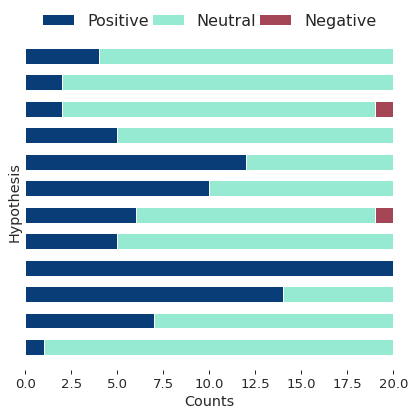

In [102]:
# Plot the results of support analysis

import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
plt.rcParams['font.family'] = 'calibri'
# Set the style and context for the plot
# Set the style and context for the plot

plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.labelsize'] = 16

responses_pnn = responses_pn

responses_pn = [(hypo, cl, RR, abstract, doi) for hypo, cl, RR, abstract, doi in responses_pn]

# Count positive, neutral, and negative responses per hypothesis
hypothesis_counts = defaultdict(lambda: {'positive': 0, 'neutral': 0, 'negative': 0})
for hypo, cl, _, _, _ in responses_pn:
    if cl == 1:
        hypothesis_counts[hypo]['positive'] += 1
    elif cl == 0:
        hypothesis_counts[hypo]['neutral'] += 1
    elif cl == -1:
        hypothesis_counts[hypo]['negative'] += 1

# Data preparation for plotting
labels = list(hypothesis_counts.keys())
positive_counts = [hypothesis_counts[hypo]['positive'] for hypo in labels]
neutral_counts = [hypothesis_counts[hypo]['neutral'] for hypo in labels]
negative_counts = [hypothesis_counts[hypo]['negative'] for hypo in labels]

# Creating the bar chart
y = range(len(labels))  # the label locations
height = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style="white", font_scale=1.2)

rects1 = ax.barh(y, positive_counts, height, label='Positive', color='#083D77')
rects2 = ax.barh(y, neutral_counts, height, left=positive_counts, label='Neutral', color='#97EAD2')
rects3 = ax.barh(y, negative_counts, height, left=[i+j for i, j in zip(positive_counts, neutral_counts)], label='Negative', color='#a54657')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Hypothesis')
ax.set_xlabel('Counts')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=16, columnspacing=0.2, facecolor='white', frameon=False, labelspacing=0.1)
plt.box(on=None)  # Turn off the box frame

# Set y-ticks
ax.set_yticks([])

# Display the plot
plt.tight_layout()

plt.savefig('Sentiment_analysis.png', dpi=600)

plt.show()


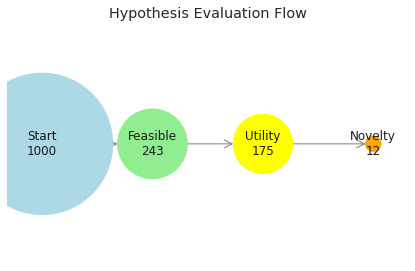

In [162]:
# plot the hypothesis evaluation flow

import matplotlib.pyplot as plt
import networkx as nx

# Counts from each step (you need to provide these counts based on your data)
total_hypotheses = 1000

feasible_count = len(selected_hypothesis_based_on_feasability)
utility_count = len(selected_hypothesis_based_on_utility)
novelty_count_3 = 12


# Create a directed graph
G = nx.DiGraph()

# Adding nodes with labels for each step
G.add_node("Start", size=total_hypotheses, label=f"Start\n{total_hypotheses}", color='lightblue')
G.add_node("Feasible", size=feasible_count, label=f"Feasible\n{feasible_count}", color='lightgreen')
G.add_node("Utility", size=utility_count, label=f"Utility\n{utility_count}", color='yellow')
G.add_node("Novelty 3", size=novelty_count_3, label=f"Novelty\n{novelty_count_3}", color='orange')

# Connecting nodes with the flow
G.add_edge("Start", "Feasible", weight=feasible_count)
G.add_edge("Feasible", "Utility", weight=utility_count)
G.add_edge("Utility", "Novelty 3", weight=novelty_count_3)

# Position nodes for better visual representation
pos = {
    "Start": (0, 0),
    "Feasible": (1, 0),
    "Utility": (2, 0),
    "Novelty 3": (3, 0),  # Branching upwards for "Very Novel"
}

# Drawing the graph
node_sizes = [G.nodes[node]['size']*20 for node in G.nodes]
node_colors = [G.nodes[node]['color'] for node in G.nodes]
labels = {node: G.nodes[node]['label'] for node in G.nodes}
nx.draw_networkx(G, pos, labels=labels, with_labels=True, node_size=node_sizes, arrowstyle='->', arrowsize=20, node_color=node_colors, edge_color='gray')

# Set plot title and remove axes for cleaner visual presentation
plt.title("Hypothesis Evaluation Flow")
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.savefig('Hypthesis_flow.png', dpi=600)

plt.show()
